In [2]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

2.6.2
2.6.0


In [3]:
from keras.layers import Input, Dense, TimeDistributed, Layer
from keras.models import Model
import keras.backend as K
from tensorflow.keras.optimizers import Adam
import numpy as np
import os

import PIL.Image
%matplotlib inline
import matplotlib.pyplot as plt

### 1. Build training permeability dataset (permeability curves)

In [3]:
# preparing 20k perm curves each having 64 points

perm_no = 20000
perm_curves_64 = np.zeros((perm_no, 64))

# (1) set all points of a perm curve as a constant sampled from 20 to 200
perm_lows = np.random.randint(20, 200, size=perm_no)
perm_curves_64 = (perm_curves_64 + 1) * np.expand_dims(perm_lows, axis = -1)

#(2) randomly select sand intervals and set high perm values for them.
for i in range(perm_no):
    # ramdomly choose sand (with high perm values) numbers for each perm curve, from 1 to 3 
    channel_no = np.random.randint(1, 3)
    # for the leftmost sand; expect the leftmost sand interval to be as left as possible, otherwise the preedicted pressure curve 
    # would decrease very quickly. Here, the left is the north in the paper.
    left_1 = np.random.randint(0, 5)
    width_1 = np.random.randint(5, 25)
    value_1 = np.random.randint(1700, 3000)
    perm_curves_64[i, left_1: left_1 + width_1] = value_1    
    
    for j in range(1, channel_no):
        left = np.random.randint(4, 60)
        width = np.random.randint(5, 25)
        value = np.random.randint(1700, 3000)
        perm_curves_64[i, left: min(left + width, 63)] = value

In [4]:
# function to downsample perm curves
def downsample_perm(orgi_perm_curve, factor = 0.5):
    orig_length = orgi_perm_curve.shape[0]

    dif_abs = np.abs(orgi_perm_curve[1:] - orgi_perm_curve[:-1])
    perm_interv_init_order = np.argwhere(dif_abs>0) + 1
    perm_interv_init_order = np.concatenate(([0], perm_interv_init_order.reshape(-1), [orig_length - 1]), axis = 0)

    interv_numb = perm_interv_init_order[1:] - perm_interv_init_order[:-1]
    interv_numb_next = np.maximum(np.round(interv_numb * factor), 1)
    interv_numb_next[np.argmax(interv_numb_next)] = np.max(interv_numb_next) - (np.sum(interv_numb_next) - orig_length * factor)
    interv_numb_next = interv_numb_next.astype(np.int)

    perm_interv_values_list = []  #np.zeros((orig_length * factor))
    for j in range(interv_numb_next.shape[0]):
        perm_interv_values_list = perm_interv_values_list + ((orgi_perm_curve[perm_interv_init_order[j] : perm_interv_init_order[j] + interv_numb_next[j]]).tolist())
    new_perm_curve = np.array(perm_interv_values_list)   
    
    return new_perm_curve


In [5]:
# obtaining 20k perm curves each having 32 points, by downsampling from the original 64-point perm curves

downsample_factor = 0.5
[perm_curve_num, perm_curve_length] = perm_curves_64.shape
perm_curves_32 = np.zeros((perm_curve_num, int(perm_curve_length * downsample_factor)))
for i in range(perm_curve_num):
    perm_curves_32[i] = downsample_perm(perm_curves_64[i], factor = downsample_factor)
    
print(perm_curves_32.shape)

(20000, 32)


In [6]:
# obtaining 20k perm curves each having 16 points, by downsampling from the original 64-point perm curves

downsample_factor = 1/4
[perm_curve_num, perm_curve_length] = perm_curves_64.shape
perm_curves_16 = np.zeros((perm_curve_num, int(perm_curve_length * downsample_factor)))
for i in range(perm_curve_num):
    perm_curves_16[i] = downsample_perm(perm_curves_64[i], factor = downsample_factor)
    
print(perm_curves_16.shape)

(20000, 16)


In [7]:
# obtaining 20k perm curves each having 8 points, by downsampling from the original 64-point perm curves

downsample_factor = 1/8
[perm_curve_num, perm_curve_length] = perm_curves_64.shape
perm_curves_8 = np.zeros((perm_curve_num, int(perm_curve_length * downsample_factor)))
for i in range(perm_curve_num):
    perm_curves_8[i] = downsample_perm(perm_curves_64[i], factor = downsample_factor)
    
print(perm_curves_8.shape)

(20000, 8)


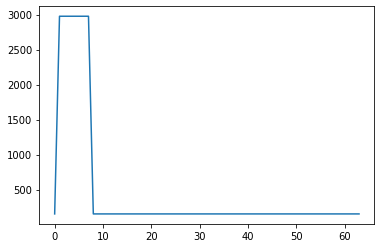

In [8]:
plt.plot(range(64), perm_curves_64[1153])

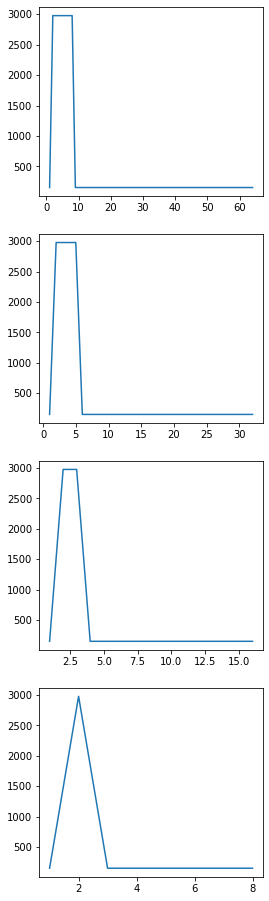

In [9]:
fig, ax = plt.subplots(4, 1)
fig.set_size_inches(4, 16, forward=True)
ax[0].plot(range(1, 65), perm_curves_64[1153])
ax[1].plot(range(1, 33), perm_curves_32[1153])
ax[2].plot(range(1, 17), perm_curves_16[1153])
ax[3].plot(range(1, 9), perm_curves_8[1153])

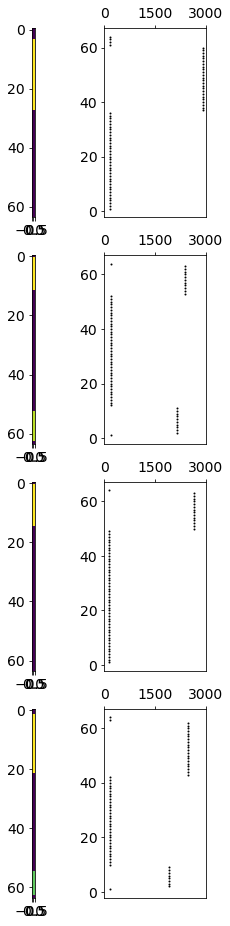

In [10]:
plt.rcParams.update({'font.size': 14})

perm_curves_64_2d = np.expand_dims(perm_curves_64, axis = -1)

fig, ax = plt.subplots(4, 2)
fig.set_size_inches(4, 16, forward=True)

ax[0, 0].imshow(perm_curves_64_2d[21])
ax[0, 1].plot(perm_curves_64_2d[21,::-1], range(1, 65), 'k.', markersize=2)
ax[0, 1].tick_params(axis='x', top=True, bottom = False)  # Set ticks on the top of X-axis
ax[0, 1].xaxis.set_tick_params(labeltop=True, labelbottom = False)
ax[0, 1].set_xlim(0, 3000)
ax[0, 1].xaxis.set_ticks((0, 1500, 3000))

ax[1, 0].imshow(perm_curves_64_2d[121])
ax[1, 1].plot(perm_curves_64_2d[121,::-1], range(1, 65), 'k.', markersize=2)
ax[1, 1].tick_params(axis='x', top=True, bottom = False)  # Set ticks on the top of X-axis
ax[1, 1].xaxis.set_tick_params(labeltop=True, labelbottom = False)
ax[1, 1].set_xlim(0, 3000)
ax[1, 1].xaxis.set_ticks((0, 1500, 3000))

ax[2, 0].imshow(perm_curves_64_2d[1121])
ax[2, 1].plot(perm_curves_64_2d[1121,::-1], range(1, 65), 'k.', markersize=2)
ax[2, 1].tick_params(axis='x', top=True, bottom = False)  # Set ticks on the top of X-axis
ax[2, 1].xaxis.set_tick_params(labeltop=True, labelbottom = False)
ax[2, 1].set_xlim(0, 3000)
ax[2, 1].xaxis.set_ticks((0, 1500, 3000))

ax[3, 0].imshow(perm_curves_64_2d[11121])
ax[3, 1].plot(perm_curves_64_2d[11121,::-1], range(1, 65), 'k.', markersize=2)
ax[3, 1].tick_params(axis='x', top=True, bottom = False)  # Set ticks on the top of X-axis
ax[3, 1].xaxis.set_tick_params(labeltop=True, labelbottom = False)
ax[3, 1].set_xlim(0, 3000)
ax[3, 1].xaxis.set_ticks((0, 1500, 3000))

### 2. Load 100 perm curves and 100 pressure curves calculated from Eclipse, for test

##### Load 100 permeability curves with 8, 16, 32, and 64 points

In [4]:
perm8_fname ='/scratch/users/suihong/MultiGrid_1D/' + 'test_perm_8.txt'
test_perm_8pixel = np.loadtxt(perm8_fname, dtype='float', delimiter= ' ')
print(test_perm_8pixel.shape)

perm16_fname ='/scratch/users/suihong/MultiGrid_1D/' + 'test_perm_16.txt'
test_perm_16pixel = np.loadtxt(perm16_fname, dtype='float', delimiter= ' ')
print(test_perm_16pixel.shape)

perm32_fname ='/scratch/users/suihong/MultiGrid_1D/' + 'test_perm_32.txt'
test_perm_32pixel = np.loadtxt(perm32_fname, dtype='float', delimiter= ' ')
print(test_perm_32pixel.shape)

perm64_fname ='/scratch/users/suihong/MultiGrid_1D/' + 'test_perm_64.txt'
test_perm_64pixel = np.loadtxt(perm64_fname, dtype='float', delimiter= ' ')
print(test_perm_64pixel.shape)

(100, 8)
(100, 16)
(100, 32)
(100, 64)


##### Load 100 pressure curves with 8, 16, 32, and 64 points

In [5]:
pres8_fname ='/scratch/users/suihong/MultiGrid_1D/' + 'test_pres_8.txt'
test_press_1day_8pixel = np.loadtxt(pres8_fname, dtype='float', delimiter= ' ')
print(test_press_1day_8pixel.shape)

pres16_fname ='/scratch/users/suihong/MultiGrid_1D/' + 'test_pres_16.txt'
test_press_1day_16pixel = np.loadtxt(pres16_fname, dtype='float', delimiter= ' ')
print(test_press_1day_16pixel.shape)

pres32_fname ='/scratch/users/suihong/MultiGrid_1D/' + 'test_pres_32.txt'
test_press_1day_32pixel = np.loadtxt(pres32_fname, dtype='float', delimiter= ' ')
print(test_press_1day_32pixel.shape)

pres64_fname ='/scratch/users/suihong/MultiGrid_1D/' + 'test_pres_64.txt'
test_press_1day_64pixel = np.loadtxt(pres64_fname, dtype='float', delimiter= ' ')
print(test_press_1day_64pixel.shape)

(100, 8)
(100, 16)
(100, 32)
(100, 64)


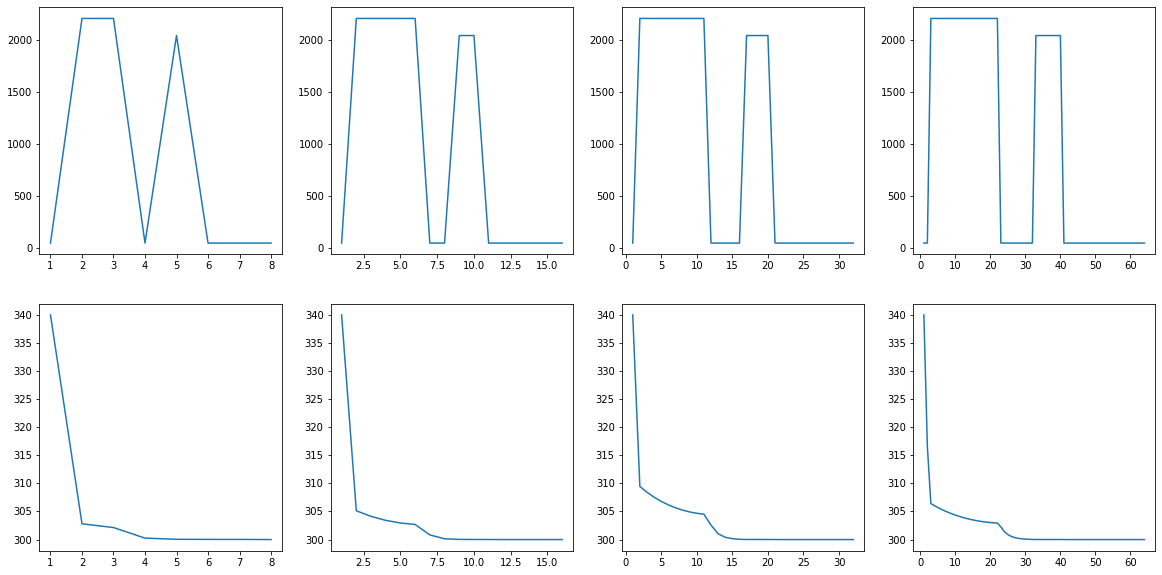

In [6]:
fig, ax = plt.subplots(2, 4)
fig.set_size_inches(20, 10, forward=True)
ax[0,0].plot(range(1, 9), test_perm_8pixel[0])
ax[1,0].plot(range(1, 9), test_press_1day_8pixel[0])
ax[0,1].plot(range(1, 17), test_perm_16pixel[0])
ax[1,1].plot(range(1, 17), test_press_1day_16pixel[0])
ax[0,2].plot(range(1, 33), test_perm_32pixel[0])
ax[1,2].plot(range(1, 33), test_press_1day_32pixel[0])
ax[0,3].plot(range(1, 65), test_perm_64pixel[0])
ax[1,3].plot(range(1, 65), test_press_1day_64pixel[0])

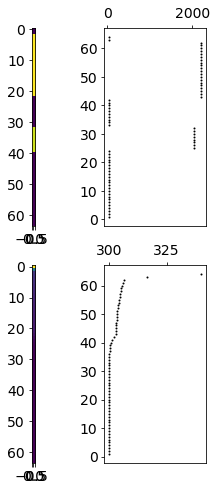

In [7]:
plt.rcParams.update({'font.size': 14})

test_perm_64pixel_2d = np.expand_dims(test_perm_64pixel, axis = -1)
test_press_1day_64pixel_2d = np.expand_dims(test_press_1day_64pixel, axis = -1)

fig, ax = plt.subplots(2, 2)
fig.set_size_inches(4, 8, forward=True)

ax[0, 0].imshow(test_perm_64pixel_2d[0])
ax[1, 0].imshow(test_press_1day_64pixel_2d[0])

ax[0, 1].plot(test_perm_64pixel_2d[0,::-1], range(1, 65), 'k.', markersize=2)
ax[0, 1].tick_params(axis='x', top=True, bottom = False)  # Set ticks on the top of X-axis
ax[0, 1].xaxis.set_tick_params(labeltop=True, labelbottom = False)

ax[1, 1].plot(test_press_1day_64pixel[0,::-1], range(1, 65), 'k.', markersize=2)
ax[1, 1].tick_params(axis='x', top=True, bottom = False)  # Set ticks on the top of X-axis
ax[1, 1].xaxis.set_tick_params(labeltop=True, labelbottom = False)

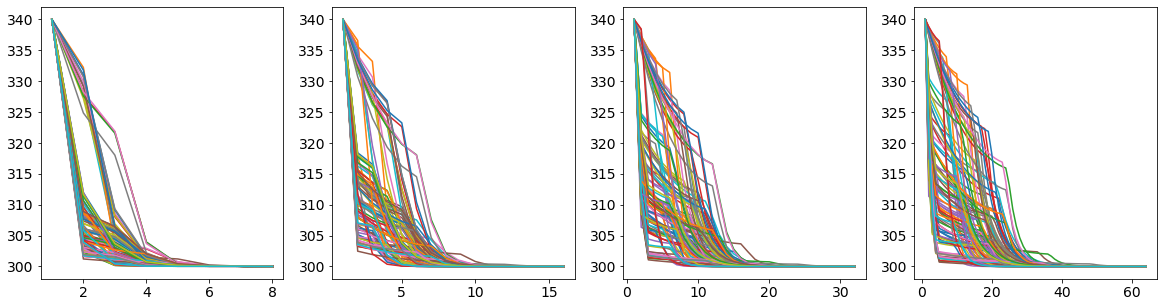

In [8]:
fig, ax = plt.subplots(1, 4)
fig.set_size_inches(20, 5, forward=True)
for i in range(100):
    ax[0].plot(range(1, 9), test_press_1day_8pixel[i])
    ax[1].plot(range(1, 17), test_press_1day_16pixel[i])
    ax[2].plot(range(1, 33), test_press_1day_32pixel[i])
    ax[3].plot(range(1, 65), test_press_1day_64pixel[i])

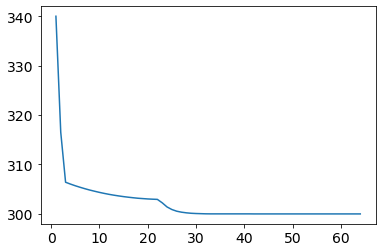

In [9]:
plt.plot(range(1, 65), test_press_1day_64pixel[0])

### 3. Train neural operator

#### (1) Define architectures, losses, and other helper functions

In [27]:
class RangeConversion(Layer):
    def __init__(self, range_in, range_out): # input and output range 
        [self.range_in_sm, self.range_in_lg] = range_in
        [self.range_out_sm, self.range_out_lg] = range_out            
        super(RangeConversion, self).__init__()
    def call(self, parameters):
        parameters_out = (parameters - self.range_in_sm) / (self.range_in_lg - self.range_in_sm) * (self.range_out_lg - self.range_out_sm) + self.range_out_sm
        return parameters_out
                    
def dense_block(x, block_lod, pixel):
    block_pixel = 2**block_lod
    with tf.compat.v1.variable_scope('%d_pixel' % block_pixel):
        layer1 = Dense(pixel*3, activation='softplus', kernel_initializer=initializer, bias_initializer= initializer)(x)
       # layer2 = Dense(pixel*3, activation='softplus', kernel_initializer=initializer, bias_initializer= initializer)(layer1)        
        return layer1            

initializer = tf.keras.initializers.GlorotNormal()    
def create_dense_model(type = 'original', pixel = 64, initializer = tf.keras.initializers.GlorotNormal()):
    # type: 'original' for original model producing pressure curve from perm curve; 
    #       'error' for error model producing pressure errors from (perm curve + residual curve) 
    # pixel: pixel number of input and output curves, a value from (64, 32, 16, 8)

    if type == 'original':
        t = Input(shape = (1, pixel,), name = 'input')
        x = RangeConversion([0, 3000], [-1, 1])(t)
    elif type == 'error':
        t = Input(shape = (2, pixel,), name = 'input')
        x = tf.concat([RangeConversion([0, 3000], [-1, 1])(t[:, 0]), t[:, 1]], axis = 1, name = 'input_rangeconversion')
    
    lod = int(np.log2(pixel))  
    for i in range(lod, 1, -1):
        x = dense_block(x, i, pixel)
    output_pre = Dense(pixel, activation='linear', kernel_initializer=initializer, bias_initializer= initializer)(x) 
    
    if type == 'original':
        output = tf.transpose(output_pre, [0, 2, 1])
    elif type == 'error':
        output = tf.expand_dims(output_pre, axis = -1)
 
    return Model(t, output)


In [28]:
# calculate residual matrix from PDE using finite difference method 
def residual_matrix(network_inputs, network_outputs):  # network_outputs of shape (N, 100, 1)      
    type = 'original' if network_inputs.shape[1] == 1 else 'error'
    pixel = network_inputs.shape[-1]
    
    dt = 1
    dx = 50.* (64 / pixel)
    miu = 2
    Ct = 1.8*10**(-2)
    unit_trans_para = 8.52702    
   
    if type == 'original':
        bound_sta_value = 340  # north boundary constant pressure value
        bound_end_value = 300  # sonth boundary constant pressure value
    elif type == 'error':
        bound_sta_value = 0
        bound_end_value = 0        
          
    bound_sta = tf.zeros(shape = (tf.shape(network_outputs)[0], 1, 1))+bound_sta_value
    bound_end = tf.zeros(shape = (tf.shape(network_outputs)[0], 1, 1))+bound_end_value  
    init_map = tf.zeros(shape = (tf.shape(network_outputs)[0], pixel, 1))+bound_end_value
    
    network_outputs = tf.concat([bound_sta, network_outputs[:, 1:-1], bound_end], axis = 1)  # shape of (N, 100, 1) 
    network_outputs = tf.concat([init_map, network_outputs], axis = 2)  # shape of (N, 100, 2) 
    
    perm = network_inputs[:, 0]
    perm = tf.expand_dims(perm, axis = 2)  # shape of (N, 100, 1)
    perm_right = (2 * perm[:, 1:-1] * perm[:, 2:])/(perm[:, 1:-1] + perm[:, 2:])
    perm_left = (2 * perm[:, 1:-1] * perm[:, :-2])/(perm[:, 1:-1] + perm[:, :-2])
    
    network_outputs_right = (network_outputs[:, 2:, 1:2] - network_outputs[:, 1:-1, 1:2])/dx
    network_outputs_left = (network_outputs[:, 1:-1, 1:2] - network_outputs[:, :-2, 1:2])/dx
    
    network_outputs_t = (network_outputs[:, 1:-1, 1:2] - network_outputs[:, 1:-1, 0:1])/dt
    
    left_term = unit_trans_para * (perm_right * network_outputs_right - perm_left * network_outputs_left)/dx
    right_term = miu * Ct * network_outputs_t   
    pde_matrix = left_term - right_term   # shape of (N, 98, 1)  
    
    if type == 'error':
        res = network_inputs[:, 1]
        pde_matrix = pde_matrix - tf.expand_dims(res[:,1:-1], axis = -1)    
    
    return pde_matrix 


def pde_loss(network_inputs, network_outputs):  # network_outputs of shape (N, 100)   network_input_permmaps of shape (N, 100)    
    pde_matrix = residual_matrix(network_inputs, network_outputs)   # shape of (N, 98, 1)
    loss = K.sqrt(K.mean((pde_matrix**2)))  # mean square root loss for each cell: sqrt((x1^2 + x2^2 + xn^2)/n);    
    return loss  # shape of (N, )


In [29]:
def residual_downscale(cur_residual):
    new_res = (cur_residual[:, :-1:2] + cur_residual[:, 1::2]) / 2
    return new_res

def level_NN_train(level, NN_type, perm, res, train_epoch = 1000, batch_size = 256, learning_rate = 1e-4):
    # level: resolution level: 64, 32, 16, 8
    # res: 1D residual with the same length as the current lvel or twice of the current level value, with shape of [N, 64]
    # perm: 1D permeability curves with shape of [N, 64] and type of 'float32' 
    # NN_type: network type, 'original' or 'error'
    
    [train_num, res_length] = res.shape        
    dense_model = create_dense_model(type = NN_type, pixel = level)
    dense_model.compile(loss = pde_loss, optimizer = Adam(lr=learning_rate), metrics = [pde_loss])
    dense_model.summary()
    
    if NN_type == 'error': 
        if res_length == 2 * level: res = residual_downscale(res)
        train_inputs = np.concatenate((np.expand_dims(perm, axis = 1), np.expand_dims(res, axis = 1)), axis = 1).astype(np.float32)
    elif NN_type == 'original':
        train_inputs = np.expand_dims(perm, axis = 1)
    
    dense_model.fit(train_inputs, train_inputs, batch_size = 256, epochs = train_epoch, \
                    verbose = 0, validation_data = (train_inputs[:50], train_inputs[:50]))

    bou_ini = 340 if NN_type == 'original' else 0
    bou_end = 300 if NN_type == 'original' else 0
    NNoutput = dense_model.predict(train_inputs)
    NNoutput[:,0] = bou_ini
    NNoutput[:,-1] = bou_end
    new_res = np.zeros((train_num, level))
    new_res[:, 1:-1] = residual_matrix(train_inputs, NNoutput)[:,:,0]
    
    return dense_model, new_res


def V_cycle_train(levels, NN_types, perms, train_epochs, ini_res):
    # levels: e.g., [64, 32, 16, 8]
    # NN_types: e.g., ['original', 'error', 'error', 'error']
    # perms: e.g., [perm_64, perm_32, perm_16, perm_8], with each perm of shape e.g., [N, 64]
    # ini_res: initial residual
    
    batch_size = 256
    learning_rate = 1e-4
    
    level_num = len(levels)
    dense_models = []

    for i in range(level_num):
        level = levels[i]
        print('training for level:' + str(level))
        NN_type = NN_types[i]
        perm = perms[i]
        if i == 0: res = ini_res  
        train_epoch = train_epochs[i]
        dense_model, new_res = level_NN_train(level, NN_type, perm, res, train_epoch)  
        dense_models.append(dense_model)
        res = new_res
     
    return dense_models
    

In [30]:
def level_NN_predict(level, NN, NN_type, perm, res):
    # level: resolution level: 64, 32, 16, 8
    # res: 1D residual with the same length as the current lvel or twice of the current level value, with shape of [N, 64]
    # perm: 1D permeability curves with shape of [N, 64] and type of 'float32' 
    # NN_type: network type, 'original' or 'error'
    
    [num, res_length] = res.shape        
    
    if NN_type == 'error': 
        if res_length == 2 * level: res = residual_downscale(res)
        NN_inputs = np.concatenate((np.expand_dims(perm, axis = 1), np.expand_dims(res, axis = 1)), axis = 1).astype(np.float32)
        bou_ini = 0
        bou_end = 0        
    elif NN_type == 'original':
        NN_inputs = np.expand_dims(perm, axis = 1)
        bou_ini = 340
        bou_end = 300

    NNoutput = NN.predict(NN_inputs)
    NNoutput[:,0] = bou_ini
    NNoutput[:,-1] = bou_end
    new_res = np.zeros(perm.shape)
    new_res[:, 1:-1] = residual_matrix(NN_inputs, NNoutput)[:,:,0]
    
    return NNoutput, new_res

def upscale(cur_curves):
    [curve_num, cur_pixel, a] = cur_curves.shape
    up_curves = np.zeros((curve_num, cur_pixel * 2, 1))
    up_curves[:,::2] = cur_curves
    up_curves[:,1:-1:2] = (up_curves[:,:-2:2] + up_curves[:,2::2])/2
    up_curves[:,-1] = up_curves[:,-2] * 2 - up_curves[:,-3]
    return up_curves


class NNs_pipeline():
    # NNs: trained neural networks from large to small levels, e.g., [NN_64, NN_32, NN_16, NN_8]
    # NN_types: e.g., ['original', 'error', 'error', 'error']
  
    def __init__(self, levels, NNs, NN_types):
        self.levels = levels
        self.NNs = NNs        
        self.NN_num = len(self.NNs)
        self.NN_types = NN_types

    def mapping(self, perms, ini_res, ini_pred):
        # perms: e.g., [perm_64, perm_32, perm_16, perm_8], with each perm of shape e.g., [N, 64]
        # ini_res: initial residual, of shape [N, 64]
        # ini_pred: initial prediction, of shape [N, 64, 1]
        
        NN_outputs = []
        for i in range(self.NN_num):
            if i == 0: res = ini_res            
            NN_output, new_res = level_NN_predict(self.levels[i], self.NNs[i], self.NN_types[i], perms[i], res)
            NN_outputs.append(NN_output)
            res = new_res
        if self.NN_types[0] == 'original':
            prediction = np.zeros(NN_outputs[-1].shape)            
            for j in range(self.NN_num - 1, 0, -1):
                prediction = - upscale(NN_outputs[j] + prediction) 
            prediction = NN_outputs[0] + prediction
        if self.NN_types[0] == 'error':
            prediction = np.zeros(NN_outputs[-1].shape)            
            for j in range(self.NN_num - 1, 0, -1):
                prediction = - upscale(NN_outputs[j] + prediction) 
            prediction = ini_pred - (NN_outputs[0] + prediction)
            
        final_res = np.zeros(perms[0].shape)
        final_res[:, 1:-1] = residual_matrix(np.expand_dims(perms[0], axis = 1), prediction)[:,:,0]
        return prediction, final_res      
            

#### (2) Train neural operator model

#### Run 1st V cycle

In [31]:
perm_curves_64 = perm_curves_64.astype('float32')
perm_curves_32 = perm_curves_32.astype('float32')
perm_curves_16 = perm_curves_16.astype('float32')
perm_curves_8 = perm_curves_8.astype('float32')

In [34]:
import time
mg_time_V1_st = time.time()

# parameter setting
levels = [8]
NN_types = ['original']
train_epochs = [200]
ini_res = np.zeros(perm_curves_8.shape)
ini_pred = np.zeros(perm_curves_8.shape)
train_perms = [perm_curves_8]
test_perms = [test_perm_8pixel]
test_ini_res = np.zeros(test_perm_8pixel.shape)
test_ini_pred = np.zeros(test_perm_8pixel.shape)

# train NNs for various levels
dense_models_C1_1 = V_cycle_train(levels, NN_types, train_perms, train_epochs, ini_res)
# build NN pipeline from perm to pressure
NNs_pipl_C1_1 = NNs_pipeline(levels, dense_models_C1_1, NN_types)
# predict pressure and residual curves using NN pipelines for train permeability curves
train_pred_1, train_res_1 = NNs_pipl_C1_1.mapping(train_perms, ini_res, ini_pred)
# predict pressure curves using NN pipelines for test permeability curves
test_pred_1, test_res_1 = NNs_pipl_C1_1.mapping(test_perms, test_ini_res, test_ini_pred)


NNs_pipl_C1_list = [NNs_pipl_C1_1]
for i in range(3):
    NN_types = ['error']
    dense_models_2 = V_cycle_train(levels, NN_types, train_perms, train_epochs, train_res_1)
    NNs_pipl_i = NNs_pipeline(levels, dense_models_2, NN_types)
    train_pred_2, train_res_2 = NNs_pipl_i.mapping(train_perms, train_res_1, train_pred_1)
    test_pred_2, test_res_2 = NNs_pipl_i.mapping(test_perms, test_res_1, test_pred_1)
    NNs_pipl_C1_list.append(NNs_pipl_i)
    train_pred_1 = train_pred_2
    train_res_1 = train_res_2
    test_pred_1 = test_pred_2
    test_res_1 = test_res_2
    
train_pred_C1 = train_pred_1
train_res_C1 = train_res_1
test_pred_C1 = test_pred_1
test_res_C1 = test_res_1

NNs_pipl_C1_1 = NNs_pipl_C1_list[0]
NNs_pipl_C1_2 = NNs_pipl_C1_list[1]
NNs_pipl_C1_3 = NNs_pipl_C1_list[2]
NNs_pipl_C1_4 = NNs_pipl_C1_list[3]

mg_time_V1_ed = time.time()
print('Seconds used: ' + str(mg_time_V1_ed - mg_time_V1_st))

training for level:8


/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1, 8)]            0         
_________________________________________________________________
range_conversion (RangeConve (None, 1, 8)              0         
_________________________________________________________________
dense (Dense)                (None, 1, 24)             216       
_________________________________________________________________
dense_1 (Dense)              (None, 1, 24)             600       
_________________________________________________________________
dense_2 (Dense)              (None, 1, 8)              200       
_________________________________________________________________
tf.compat.v1.transpose (TFOp (None, 8, 1)              0         
Total params: 1,016
Trainable params: 1,016
Non-trainable params: 0
___________________________________________________________

/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


training for level:8
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 2, 8)]       0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None, 8)            0           input[0][0]                      
__________________________________________________________________________________________________
range_conversion_2 (RangeConver (None, 8)            0           tf.__operators__.getitem_2[0][0] 
__________________________________________________________________________________________________
tf.__operators__.getitem_3 (Sli (None, 8)            0           input[0][0]                      
_______________________________________________________________________

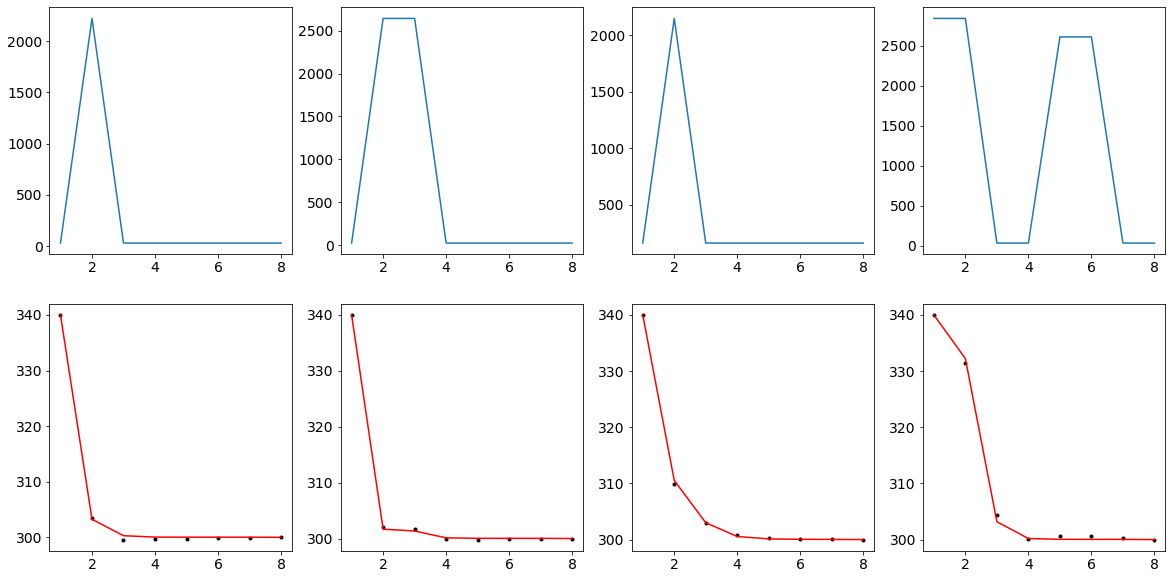

In [35]:
# draw predicted pressure curves for test perm data
pixel = 8
fig, ax = plt.subplots(2, 4)
fig.set_size_inches(20, 10, forward=True)
ax[0, 0].plot(range(1, pixel + 1), test_perm_8pixel[55])
ax[1, 0].plot(range(1, pixel + 1), test_pred_C1[55], 'k.')
ax[1, 0].plot(range(1, pixel + 1), test_press_1day_8pixel[55], 'r-')
ax[0, 1].plot(range(1, pixel + 1), test_perm_8pixel[14])
ax[1, 1].plot(range(1, pixel + 1), test_pred_C1[14], 'k.')
ax[1, 1].plot(range(1, pixel + 1), test_press_1day_8pixel[14], 'r-')
ax[0, 2].plot(range(1, pixel + 1), test_perm_8pixel[64])
ax[1, 2].plot(range(1, pixel + 1), test_pred_C1[64], 'k.')
ax[1, 2].plot(range(1, pixel + 1), test_press_1day_8pixel[64], 'r-')
ax[0, 3].plot(range(1, pixel + 1), test_perm_8pixel[21])
ax[1, 3].plot(range(1, pixel + 1), test_pred_C1[21], 'k.')
ax[1, 3].plot(range(1, pixel + 1), test_press_1day_8pixel[21], 'r-')  

In [36]:
len(NNs_pipl_C1_list)

4

### Run 2nd V cycle

In [35]:
def upscale(cur_curves):  # [N, 8, 1]
    curve_num = cur_curves.shape[0]
    cur_pixel = cur_curves.shape[1]
    up_curves = np.zeros((curve_num, cur_pixel * 2, cur_curves.shape[-1]))  # [N, 16, 1]
    up_curves[:, ::2] = cur_curves
    up_curves[:, 1:-1:2] = (up_curves[:, :-2:2] + up_curves[:, 2::2]) / 2  
    up_curves[:, -1] = 2 * up_curves[:, -2] - up_curves[:, -3]
    return up_curves

In [36]:

train_pred_C1 = upscale(train_pred_C1)
train_res_C1 = np.zeros((train_pred_C1.shape[0], train_pred_C1.shape[1]))
train_res_C1[:, 1:-1] = residual_matrix(perm_curves_16[:, np.newaxis, :], train_pred_C1)[:,:,0]
    

In [39]:
mg_time_V1_st = time.time()

# parameter setting
levels = [16, 8]
NN_types = ['error', 'error']
train_epochs = [200, 200]
train_perms = [perm_curves_16, perm_curves_8]
# train NNs for various levels
dense_models_C2 = V_cycle_train(levels, NN_types, train_perms, train_epochs, train_res_C1)
# build NN pipeline from perm to pressure
NNs_pipl_C2 = NNs_pipeline(levels, dense_models_C2, NN_types)
# predict pressure and residual curves using NN pipelines for train permeability curves
train_pred_C2, train_res_C2 = NNs_pipl_C2.mapping(train_perms, train_res_C1, train_pred_C1)

mg_time_V1_ed = time.time()
print('Seconds used: ' + str(mg_time_V1_ed - mg_time_V1_st))

training for level:16
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 2, 16)]      0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_6 (Sli (None, 16)           0           input[0][0]                      
__________________________________________________________________________________________________
range_conversion_4 (RangeConver (None, 16)           0           tf.__operators__.getitem_6[0][0] 
__________________________________________________________________________________________________
tf.__operators__.getitem_7 (Sli (None, 16)           0           input[0][0]                      
______________________________________________________________________

/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


training for level:8
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 2, 8)]       0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_8 (Sli (None, 8)            0           input[0][0]                      
__________________________________________________________________________________________________
range_conversion_5 (RangeConver (None, 8)            0           tf.__operators__.getitem_8[0][0] 
__________________________________________________________________________________________________
tf.__operators__.getitem_9 (Sli (None, 8)            0           input[0][0]                      
_______________________________________________________________________

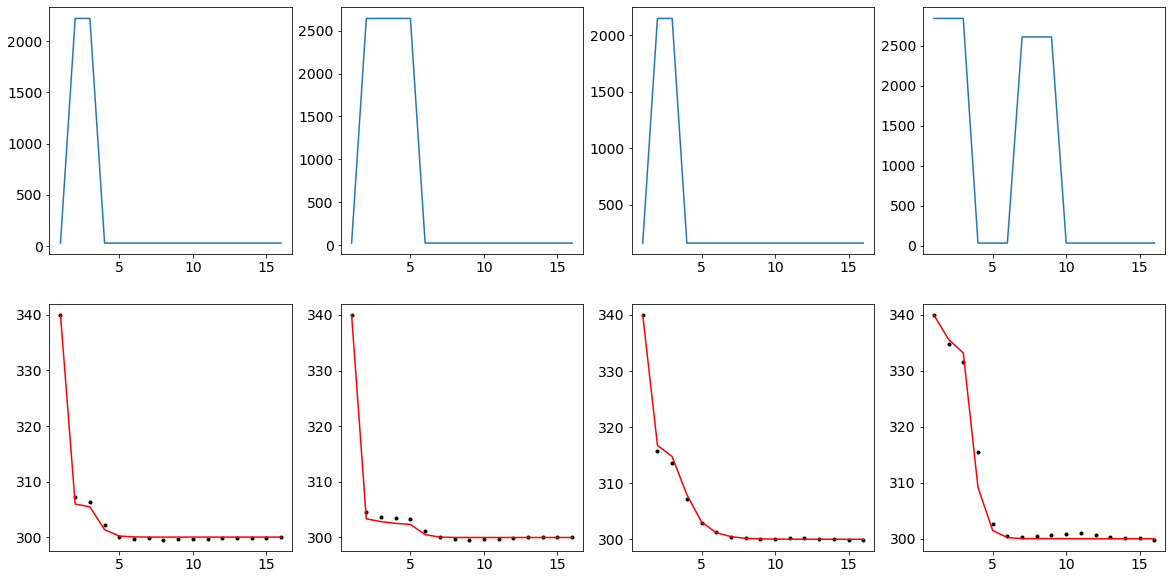

In [40]:
# predict pressure curves using NN pipelines for test permeability curves
test_perms = [test_perm_16pixel, test_perm_8pixel]

test_pred_C1_up = upscale(test_pred_C1)
test_res_C1_up = np.zeros((test_pred_C1_up.shape[0], test_pred_C1_up.shape[1]))
test_res_C1_up[:, 1:-1] = residual_matrix(test_perm_16pixel[:, np.newaxis, :], test_pred_C1_up)[:,:,0]

test_pred_C2, test_res_C2 = NNs_pipl_C2.mapping(test_perms, test_res_C1_up, test_pred_C1_up)

# draw predicted pressure curves for test perm data
pixel = 16
fig, ax = plt.subplots(2, 4)
fig.set_size_inches(20, 10, forward=True)
ax[0, 0].plot(range(1, pixel + 1), test_perm_16pixel[55])
ax[1, 0].plot(range(1, pixel + 1), test_pred_C2[55], 'k.')
ax[1, 0].plot(range(1, pixel + 1), test_press_1day_16pixel[55], 'r-')
ax[0, 1].plot(range(1, pixel + 1), test_perm_16pixel[14])
ax[1, 1].plot(range(1, pixel + 1), test_pred_C2[14], 'k.')
ax[1, 1].plot(range(1, pixel + 1), test_press_1day_16pixel[14], 'r-')
ax[0, 2].plot(range(1, pixel + 1), test_perm_16pixel[64])
ax[1, 2].plot(range(1, pixel + 1), test_pred_C2[64], 'k.')
ax[1, 2].plot(range(1, pixel + 1), test_press_1day_16pixel[64], 'r-')
ax[0, 3].plot(range(1, pixel + 1), test_perm_16pixel[21])
ax[1, 3].plot(range(1, pixel + 1), test_pred_C2[21], 'k.')
ax[1, 3].plot(range(1, pixel + 1), test_press_1day_16pixel[21], 'r-')  

### Run 3rd V cycle

In [41]:
mg_time_V1_st = time.time()

# parameter setting
levels = [32, 16, 8]
NN_types = ['error', 'error', 'error']
train_epochs = [200, 200, 200]
train_perms = [perm_curves_32, perm_curves_16, perm_curves_8]

train_pred_C2 = upscale(train_pred_C2)
train_res_C2 = np.zeros((train_pred_C2.shape[0], train_pred_C2.shape[1]))
train_res_C2[:, 1:-1] = residual_matrix(perm_curves_32[:, np.newaxis, :], train_pred_C2)[:,:,0]

# train NNs for various levels
dense_models_C3 = V_cycle_train(levels, NN_types, train_perms, train_epochs, train_res_C2)
# build NN pipeline from perm to pressure
NNs_pipl_C3 = NNs_pipeline(levels, dense_models_C3, NN_types)
# predict pressure and residual curves using NN pipelines for train permeability curves
train_pred_C3, train_res_C3 = NNs_pipl_C3.mapping(train_perms, train_res_C2, train_pred_C2)

mg_time_V1_ed = time.time()
print('Seconds used: ' + str(mg_time_V1_ed - mg_time_V1_st))

training for level:32
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 2, 32)]      0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_10 (Sl (None, 32)           0           input[0][0]                      
__________________________________________________________________________________________________
range_conversion_6 (RangeConver (None, 32)           0           tf.__operators__.getitem_10[0][0]
__________________________________________________________________________________________________
tf.__operators__.getitem_11 (Sl (None, 32)           0           input[0][0]                      
______________________________________________________________________

/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


training for level:16
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 2, 16)]      0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_12 (Sl (None, 16)           0           input[0][0]                      
__________________________________________________________________________________________________
range_conversion_7 (RangeConver (None, 16)           0           tf.__operators__.getitem_12[0][0]
__________________________________________________________________________________________________
tf.__operators__.getitem_13 (Sl (None, 16)           0           input[0][0]                      
______________________________________________________________________

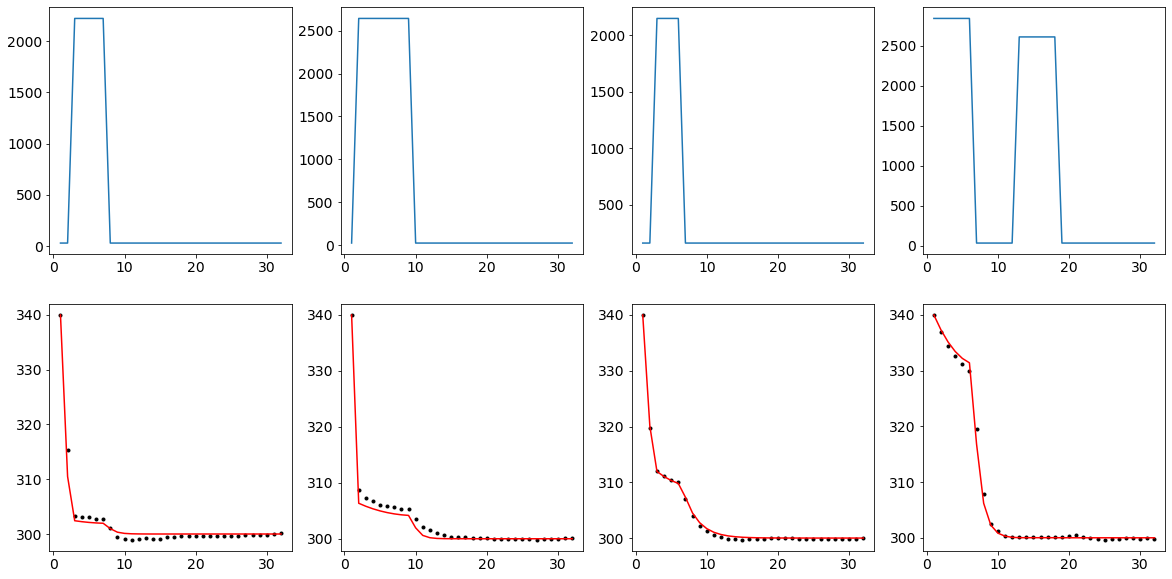

In [42]:
test_perms = [test_perm_32pixel, test_perm_16pixel, test_perm_8pixel]

test_pred_C2_up = upscale(test_pred_C2)
test_res_C2_up = np.zeros((test_pred_C2_up.shape[0], test_pred_C2_up.shape[1]))
test_res_C2_up[:, 1:-1] = residual_matrix(test_perm_32pixel[:, np.newaxis, :], test_pred_C2_up)[:,:,0]


# predict pressure curves using NN pipelines for test permeability curves
test_pred_C3, test_res_C3 = NNs_pipl_C3.mapping(test_perms, test_res_C2_up, test_pred_C2_up)

# draw predicted pressure curves for test perm data
pixel = 32
fig, ax = plt.subplots(2, 4)
fig.set_size_inches(20, 10, forward=True)
ax[0, 0].plot(range(1, pixel + 1), test_perm_32pixel[55])
ax[1, 0].plot(range(1, pixel + 1), test_pred_C3[55], 'k.')
ax[1, 0].plot(range(1, pixel + 1), test_press_1day_32pixel[55], 'r-')
ax[0, 1].plot(range(1, pixel + 1), test_perm_32pixel[14])
ax[1, 1].plot(range(1, pixel + 1), test_pred_C3[14], 'k.')
ax[1, 1].plot(range(1, pixel + 1), test_press_1day_32pixel[14], 'r-')
ax[0, 2].plot(range(1, pixel + 1), test_perm_32pixel[64])
ax[1, 2].plot(range(1, pixel + 1), test_pred_C3[64], 'k.')
ax[1, 2].plot(range(1, pixel + 1), test_press_1day_32pixel[64], 'r-')
ax[0, 3].plot(range(1, pixel + 1), test_perm_32pixel[21])
ax[1, 3].plot(range(1, pixel + 1), test_pred_C3[21], 'k.')
ax[1, 3].plot(range(1, pixel + 1), test_press_1day_32pixel[21], 'r-')  

### Run 4th V cycle

In [43]:
mg_time_V1_st = time.time()

# parameter setting
levels = [32, 16, 8]
NN_types = ['error', 'error', 'error']
train_epochs = [200, 200, 200]
train_perms = [perm_curves_32, perm_curves_16, perm_curves_8]

# train NNs for various levels
dense_models_C4 = V_cycle_train(levels, NN_types, train_perms, train_epochs, train_res_C3)
# build NN pipeline from perm to pressure
NNs_pipl_C4 = NNs_pipeline(levels, dense_models_C4, NN_types)
# predict pressure and residual curves using NN pipelines for train permeability curves
train_pred_C4, train_res_C4 = NNs_pipl_C4.mapping(train_perms, train_res_C3, train_pred_C3)

mg_time_V1_ed = time.time()
print('Seconds used: ' + str(mg_time_V1_ed - mg_time_V1_st))

training for level:32
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 2, 32)]      0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_16 (Sl (None, 32)           0           input[0][0]                      
__________________________________________________________________________________________________
range_conversion_9 (RangeConver (None, 32)           0           tf.__operators__.getitem_16[0][0]
__________________________________________________________________________________________________
tf.__operators__.getitem_17 (Sl (None, 32)           0           input[0][0]                      
______________________________________________________________________

/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


training for level:16
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 2, 16)]      0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_18 (Sl (None, 16)           0           input[0][0]                      
__________________________________________________________________________________________________
range_conversion_10 (RangeConve (None, 16)           0           tf.__operators__.getitem_18[0][0]
__________________________________________________________________________________________________
tf.__operators__.getitem_19 (Sl (None, 16)           0           input[0][0]                      
_____________________________________________________________________

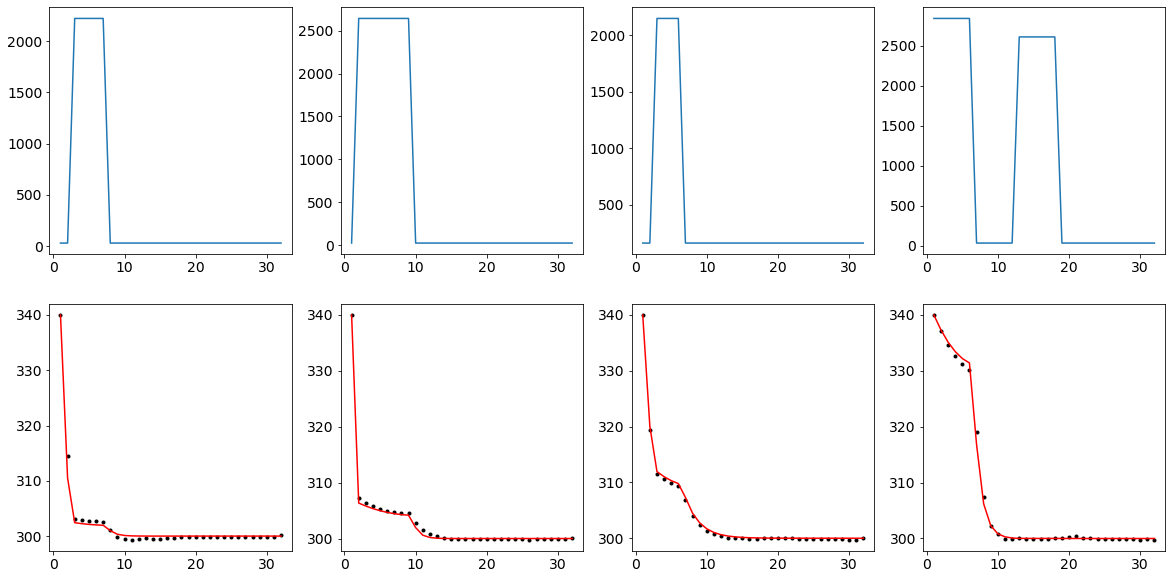

In [44]:
test_perms = [test_perm_32pixel, test_perm_16pixel, test_perm_8pixel]

# predict pressure curves using NN pipelines for test permeability curves
test_pred_C4, test_res_C4 = NNs_pipl_C4.mapping(test_perms, test_res_C3, test_pred_C3)

# draw predicted pressure curves for test perm data
pixel = 32
fig, ax = plt.subplots(2, 4)
fig.set_size_inches(20, 10, forward=True)
ax[0, 0].plot(range(1, pixel + 1), test_perm_32pixel[55])
ax[1, 0].plot(range(1, pixel + 1), test_pred_C4[55], 'k.')
ax[1, 0].plot(range(1, pixel + 1), test_press_1day_32pixel[55], 'r-')
ax[0, 1].plot(range(1, pixel + 1), test_perm_32pixel[14])
ax[1, 1].plot(range(1, pixel + 1), test_pred_C4[14], 'k.')
ax[1, 1].plot(range(1, pixel + 1), test_press_1day_32pixel[14], 'r-')
ax[0, 2].plot(range(1, pixel + 1), test_perm_32pixel[64])
ax[1, 2].plot(range(1, pixel + 1), test_pred_C4[64], 'k.')
ax[1, 2].plot(range(1, pixel + 1), test_press_1day_32pixel[64], 'r-')
ax[0, 3].plot(range(1, pixel + 1), test_perm_32pixel[21])
ax[1, 3].plot(range(1, pixel + 1), test_pred_C4[21], 'k.')
ax[1, 3].plot(range(1, pixel + 1), test_press_1day_32pixel[21], 'r-') 

### Run 5th V cycle

In [45]:
mg_time_V1_st = time.time()

# parameter setting
levels = [64, 32, 16, 8]
NN_types = ['error', 'error', 'error', 'error']
train_epochs = [200, 200, 200, 200]
train_perms = [perm_curves_64, perm_curves_32, perm_curves_16, perm_curves_8]

train_pred_C4 = upscale(train_pred_C4)
train_res_C4 = np.zeros((train_pred_C4.shape[0], train_pred_C4.shape[1]))
train_res_C4[:, 1:-1] = residual_matrix(perm_curves_64[:, np.newaxis, :], train_pred_C4)[:,:,0]

# train NNs for various levels
dense_models_C5 = V_cycle_train(levels, NN_types, train_perms, train_epochs, train_res_C4)
# build NN pipeline from perm to pressure
NNs_pipl_C5 = NNs_pipeline(levels, dense_models_C5, NN_types)
# predict pressure and residual curves using NN pipelines for train permeability curves
train_pred_C5, train_res_C5 = NNs_pipl_C5.mapping(train_perms, train_res_C4, train_pred_C4) 

mg_time_V1_ed = time.time()
print('Seconds used: ' + str(mg_time_V1_ed - mg_time_V1_st))

training for level:64
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 2, 64)]      0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_22 (Sl (None, 64)           0           input[0][0]                      
__________________________________________________________________________________________________
range_conversion_12 (RangeConve (None, 64)           0           tf.__operators__.getitem_22[0][0]
__________________________________________________________________________________________________
tf.__operators__.getitem_23 (Sl (None, 64)           0           input[0][0]                      
_____________________________________________________________________

/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


training for level:32
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 2, 32)]      0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_24 (Sl (None, 32)           0           input[0][0]                      
__________________________________________________________________________________________________
range_conversion_13 (RangeConve (None, 32)           0           tf.__operators__.getitem_24[0][0]
__________________________________________________________________________________________________
tf.__operators__.getitem_25 (Sl (None, 32)           0           input[0][0]                      
_____________________________________________________________________

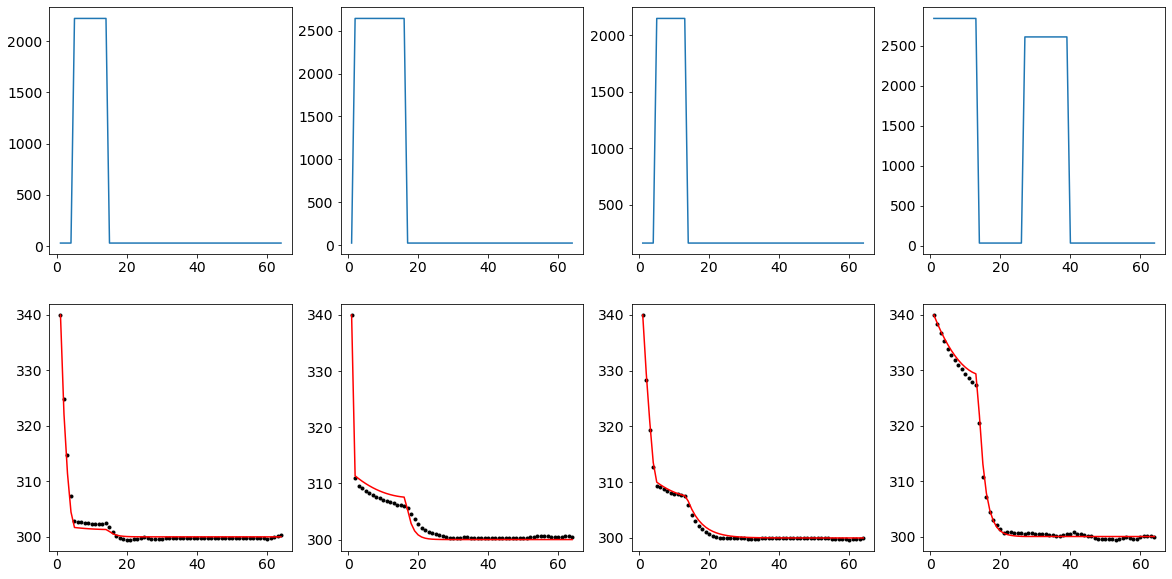

In [46]:
test_perms = [test_perm_64pixel, test_perm_32pixel, test_perm_16pixel, test_perm_8pixel]

test_pred_C4_up = upscale(test_pred_C4)
test_res_C4_up = np.zeros((test_pred_C4_up.shape[0], test_pred_C4_up.shape[1]))
test_res_C4_up[:, 1:-1] = residual_matrix(test_perm_64pixel[:, np.newaxis, :], test_pred_C4_up)[:,:,0]
# predict pressure curves using NN pipelines for test permeability curves

test_pred_C5, test_res_C5 = NNs_pipl_C5.mapping(test_perms, test_res_C4_up, test_pred_C4_up)

# draw predicted pressure curves for test perm data
pixel = 64
fig, ax = plt.subplots(2, 4)
fig.set_size_inches(20, 10, forward=True)
ax[0, 0].plot(range(1, pixel + 1), test_perm_64pixel[55])
ax[1, 0].plot(range(1, pixel + 1), test_pred_C5[55], 'k.')
ax[1, 0].plot(range(1, pixel + 1), test_press_1day_64pixel[55], 'r-')
ax[0, 1].plot(range(1, pixel + 1), test_perm_64pixel[14])
ax[1, 1].plot(range(1, pixel + 1), test_pred_C5[14], 'k.')
ax[1, 1].plot(range(1, pixel + 1), test_press_1day_64pixel[14], 'r-')
ax[0, 2].plot(range(1, pixel + 1), test_perm_64pixel[64])
ax[1, 2].plot(range(1, pixel + 1), test_pred_C5[64], 'k.')
ax[1, 2].plot(range(1, pixel + 1), test_press_1day_64pixel[64], 'r-')
ax[0, 3].plot(range(1, pixel + 1), test_perm_64pixel[21])
ax[1, 3].plot(range(1, pixel + 1), test_pred_C5[21], 'k.')
ax[1, 3].plot(range(1, pixel + 1), test_press_1day_64pixel[21], 'r-') 

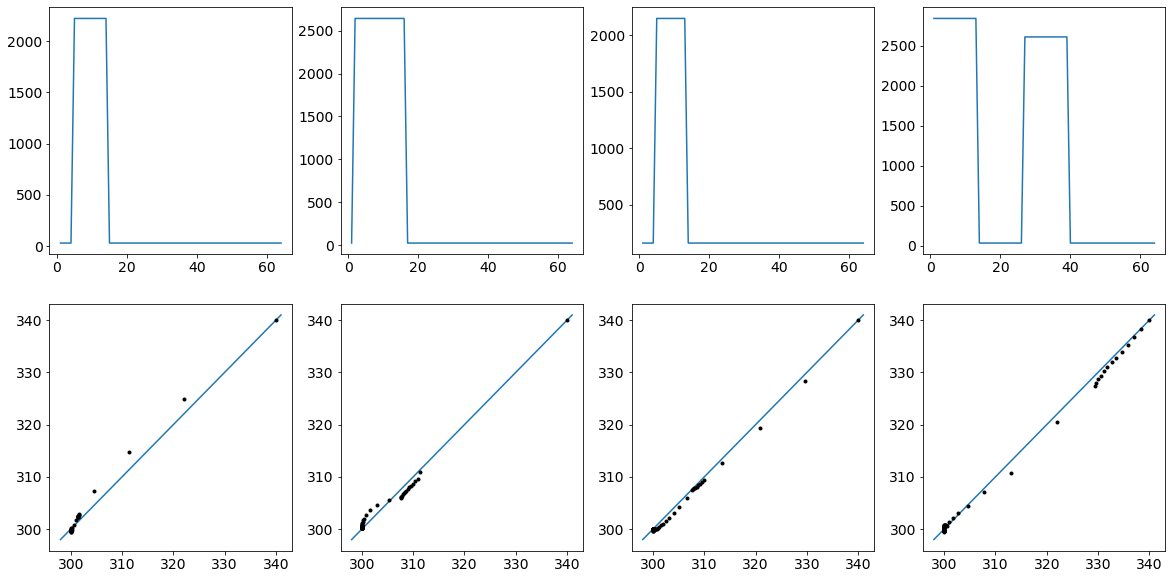

In [47]:
# draw predicted pressure curves for test perm data
pixel = 64
fig, ax = plt.subplots(2, 4)
fig.set_size_inches(20, 10, forward=True)
ax[0, 0].plot(range(1, pixel + 1), test_perm_64pixel[55])
ax[1, 0].plot(range(298, 342), range(298, 342))
ax[1, 0].plot(test_press_1day_64pixel[55], test_pred_C5[55], 'k.')

ax[0, 1].plot(range(1, pixel + 1), test_perm_64pixel[14])
ax[1, 1].plot(range(298, 342), range(298, 342))
ax[1, 1].plot(test_press_1day_64pixel[14], test_pred_C5[14], 'k.')

ax[0, 2].plot(range(1, pixel + 1), test_perm_64pixel[64])
ax[1, 2].plot(range(298, 342), range(298, 342))
ax[1, 2].plot(test_press_1day_64pixel[64], test_pred_C5[64], 'k.')

ax[0, 3].plot(range(1, pixel + 1), test_perm_64pixel[21])
ax[1, 3].plot(range(298, 342), range(298, 342))
ax[1, 3].plot(test_press_1day_64pixel[21], test_pred_C5[21], 'k.')

### Run 6th V cycle

In [48]:
mg_time_V1_st = time.time()


# parameter setting
levels = [64, 32, 16, 8]
NN_types = ['error', 'error', 'error', 'error']
train_epochs = [200, 200, 200, 200]
train_perms = [perm_curves_64, perm_curves_32, perm_curves_16, perm_curves_8]

# train NNs for various levels
dense_models_C6 = V_cycle_train(levels, NN_types, train_perms, train_epochs, train_res_C5)
# build NN pipeline from perm to pressure
NNs_pipl_C6 = NNs_pipeline(levels, dense_models_C6, NN_types)
# predict pressure and residual curves using NN pipelines for train permeability curves
train_pred_C6, train_res_C6 = NNs_pipl_C6.mapping(train_perms, train_res_C5, train_pred_C5) 

mg_time_V1_ed = time.time()
print('Seconds used: ' + str(mg_time_V1_ed - mg_time_V1_st))

training for level:64
Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 2, 64)]      0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_30 (Sl (None, 64)           0           input[0][0]                      
__________________________________________________________________________________________________
range_conversion_16 (RangeConve (None, 64)           0           tf.__operators__.getitem_30[0][0]
__________________________________________________________________________________________________
tf.__operators__.getitem_31 (Sl (None, 64)           0           input[0][0]                      
_____________________________________________________________________

/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


training for level:32
Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 2, 32)]      0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_32 (Sl (None, 32)           0           input[0][0]                      
__________________________________________________________________________________________________
range_conversion_17 (RangeConve (None, 32)           0           tf.__operators__.getitem_32[0][0]
__________________________________________________________________________________________________
tf.__operators__.getitem_33 (Sl (None, 32)           0           input[0][0]                      
_____________________________________________________________________

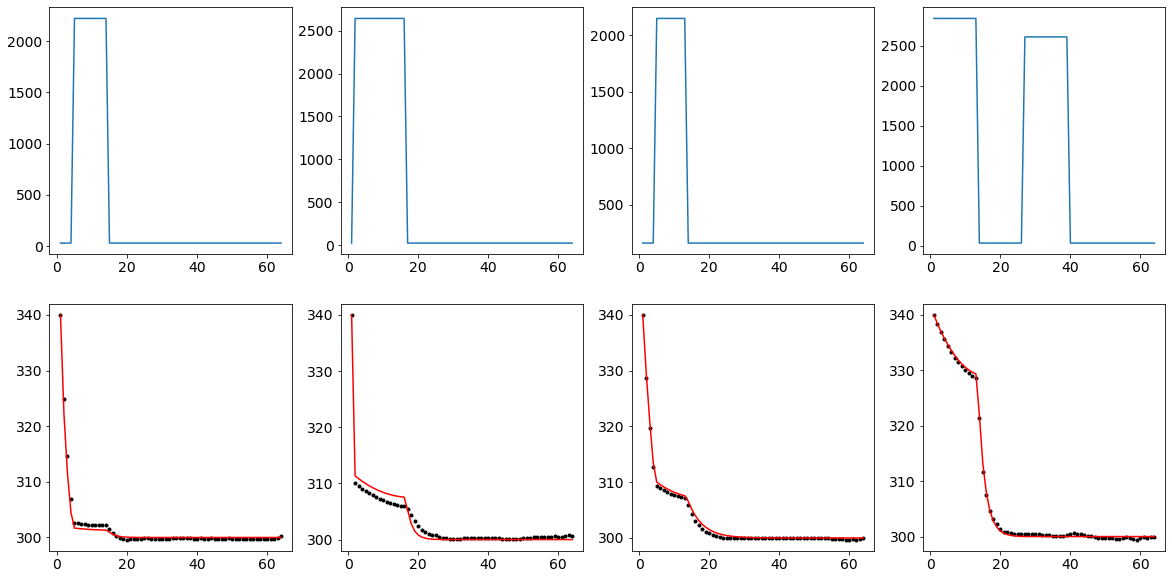

In [49]:
# predict pressure curves using NN pipelines for test permeability curves
test_perms = [test_perm_64pixel, test_perm_32pixel, test_perm_16pixel, test_perm_8pixel]
test_pred_C6, test_res_C6 = NNs_pipl_C6.mapping(test_perms, test_res_C5, test_pred_C5)

# draw predicted pressure curves for test perm data
pixel = 64
fig, ax = plt.subplots(2, 4)
fig.set_size_inches(20, 10, forward=True)
ax[0, 0].plot(range(1, pixel + 1), test_perm_64pixel[55])
ax[1, 0].plot(range(1, pixel + 1), test_pred_C6[55], 'k.')
ax[1, 0].plot(range(1, pixel + 1), test_press_1day_64pixel[55], 'r-')
ax[0, 1].plot(range(1, pixel + 1), test_perm_64pixel[14])
ax[1, 1].plot(range(1, pixel + 1), test_pred_C6[14], 'k.')
ax[1, 1].plot(range(1, pixel + 1), test_press_1day_64pixel[14], 'r-')
ax[0, 2].plot(range(1, pixel + 1), test_perm_64pixel[64])
ax[1, 2].plot(range(1, pixel + 1), test_pred_C6[64], 'k.')
ax[1, 2].plot(range(1, pixel + 1), test_press_1day_64pixel[64], 'r-')
ax[0, 3].plot(range(1, pixel + 1), test_perm_64pixel[21])
ax[1, 3].plot(range(1, pixel + 1), test_pred_C6[21], 'k.')
ax[1, 3].plot(range(1, pixel + 1), test_press_1day_64pixel[21], 'r-') 

### Run 7th V cycle

In [50]:
mg_time_V1_st = time.time()

# parameter setting
levels = [64, 32]
NN_types = ['error', 'error']
train_epochs = [200, 200]
train_perms = [perm_curves_64, perm_curves_32]
# train NNs for various levels
dense_models_C7 = V_cycle_train(levels, NN_types, train_perms, train_epochs, train_res_C6)
# build NN pipeline from perm to pressure
NNs_pipl_C7 = NNs_pipeline(levels, dense_models_C7, NN_types)
# predict pressure and residual curves using NN pipelines for train permeability curves
train_pred_C7, train_res_C7 = NNs_pipl_C7.mapping(train_perms, train_res_C6, train_pred_C6) 

mg_time_V1_ed = time.time()
print('Seconds used: ' + str(mg_time_V1_ed - mg_time_V1_st))

training for level:64
Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 2, 64)]      0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_38 (Sl (None, 64)           0           input[0][0]                      
__________________________________________________________________________________________________
range_conversion_20 (RangeConve (None, 64)           0           tf.__operators__.getitem_38[0][0]
__________________________________________________________________________________________________
tf.__operators__.getitem_39 (Sl (None, 64)           0           input[0][0]                      
_____________________________________________________________________

/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


training for level:32
Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 2, 32)]      0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_40 (Sl (None, 32)           0           input[0][0]                      
__________________________________________________________________________________________________
range_conversion_21 (RangeConve (None, 32)           0           tf.__operators__.getitem_40[0][0]
__________________________________________________________________________________________________
tf.__operators__.getitem_41 (Sl (None, 32)           0           input[0][0]                      
_____________________________________________________________________

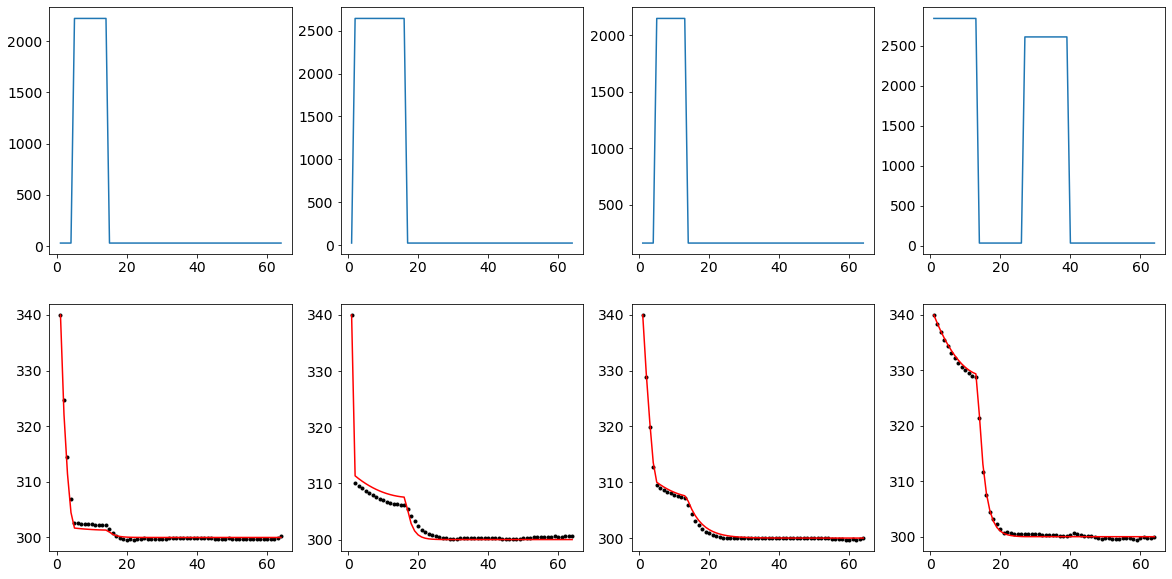

In [51]:
test_perms = [test_perm_64pixel, test_perm_32pixel]
# predict pressure curves using NN pipelines for test permeability curves
test_pred_C7, test_res_C7 = NNs_pipl_C7.mapping(test_perms, test_res_C6, test_pred_C6)

# draw predicted pressure curves for test perm data
pixel = 64
fig, ax = plt.subplots(2, 4)
fig.set_size_inches(20, 10, forward=True)
ax[0, 0].plot(range(1, pixel + 1), test_perm_64pixel[55])
ax[1, 0].plot(range(1, pixel + 1), test_pred_C7[55], 'k.')
ax[1, 0].plot(range(1, pixel + 1), test_press_1day_64pixel[55], 'r-')
ax[0, 1].plot(range(1, pixel + 1), test_perm_64pixel[14])
ax[1, 1].plot(range(1, pixel + 1), test_pred_C7[14], 'k.')
ax[1, 1].plot(range(1, pixel + 1), test_press_1day_64pixel[14], 'r-')
ax[0, 2].plot(range(1, pixel + 1), test_perm_64pixel[64])
ax[1, 2].plot(range(1, pixel + 1), test_pred_C7[64], 'k.')
ax[1, 2].plot(range(1, pixel + 1), test_press_1day_64pixel[64], 'r-')
ax[0, 3].plot(range(1, pixel + 1), test_perm_64pixel[21])
ax[1, 3].plot(range(1, pixel + 1), test_pred_C7[21], 'k.')
ax[1, 3].plot(range(1, pixel + 1), test_press_1day_64pixel[21], 'r-') 


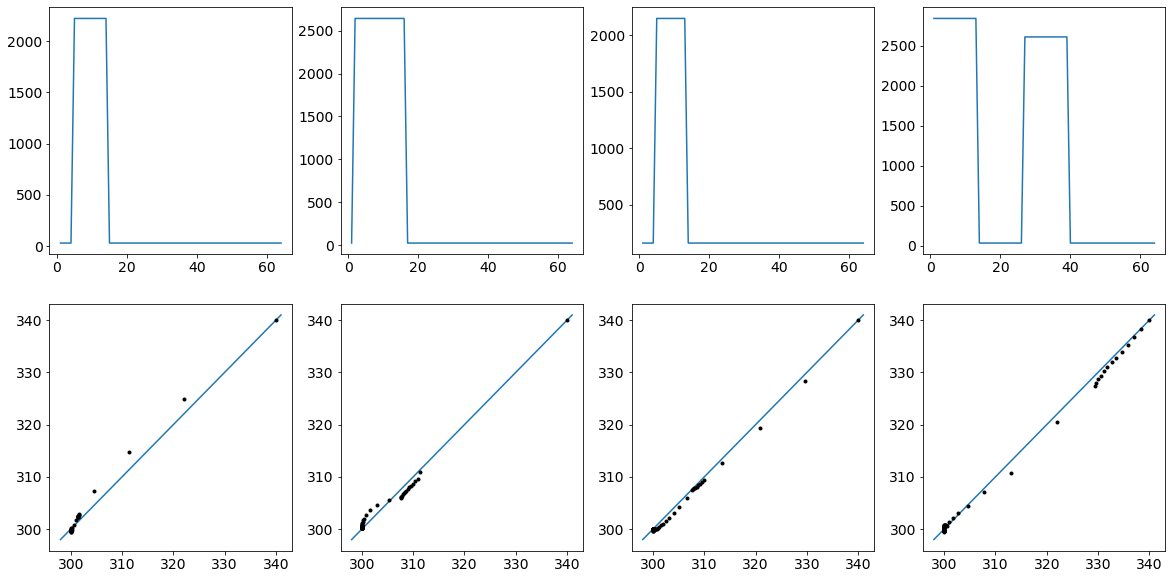

In [52]:
# draw predicted pressure curves for test perm data
pixel = 64
fig, ax = plt.subplots(2, 4)
fig.set_size_inches(20, 10, forward=True)
ax[0, 0].plot(range(1, pixel + 1), test_perm_64pixel[55])
ax[1, 0].plot(range(298, 342), range(298, 342))
ax[1, 0].plot(test_press_1day_64pixel[55], test_pred_C5[55], 'k.')

ax[0, 1].plot(range(1, pixel + 1), test_perm_64pixel[14])
ax[1, 1].plot(range(298, 342), range(298, 342))
ax[1, 1].plot(test_press_1day_64pixel[14], test_pred_C5[14], 'k.')

ax[0, 2].plot(range(1, pixel + 1), test_perm_64pixel[64])
ax[1, 2].plot(range(298, 342), range(298, 342))
ax[1, 2].plot(test_press_1day_64pixel[64], test_pred_C5[64], 'k.')

ax[0, 3].plot(range(1, pixel + 1), test_perm_64pixel[21])
ax[1, 3].plot(range(298, 342), range(298, 342))
ax[1, 3].plot(test_press_1day_64pixel[21], test_pred_C5[21], 'k.')

### Run 8th V cycle

training for level:64
Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 2, 64)]      0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_42 (Sl (None, 64)           0           input[0][0]                      
__________________________________________________________________________________________________
range_conversion_22 (RangeConve (None, 64)           0           tf.__operators__.getitem_42[0][0]
__________________________________________________________________________________________________
tf.__operators__.getitem_43 (Sl (None, 64)           0           input[0][0]                      
_____________________________________________________________________

/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Seconds used: 61.0675413608551


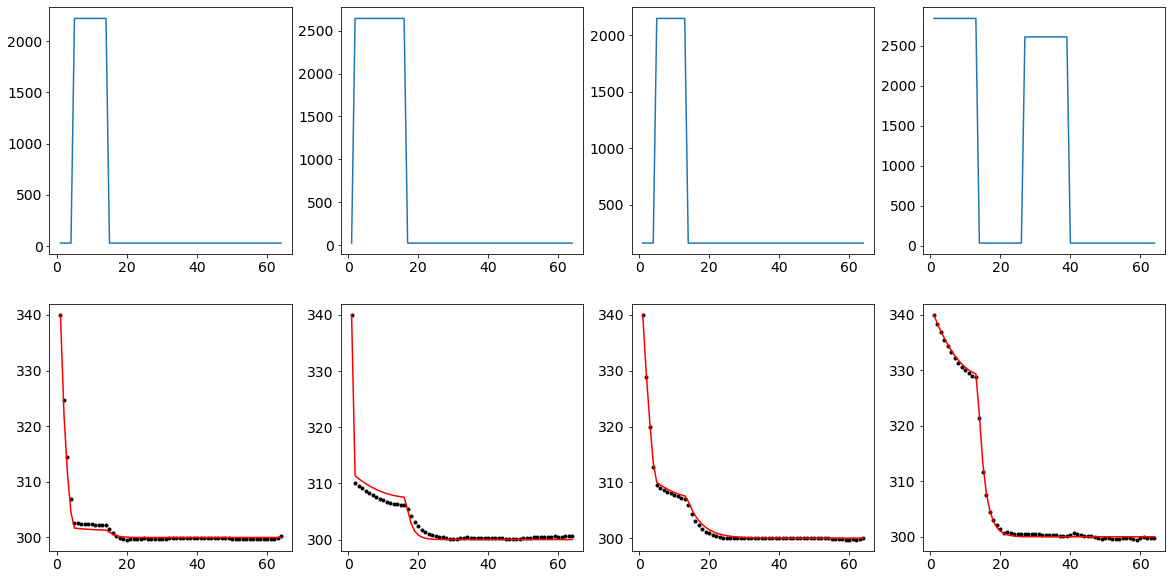

In [53]:
mg_time_V1_st = time.time()

# parameter setting
levels = [64]
NN_types = ['error']
train_epochs = [200]
train_perms = [perm_curves_64]
# train NNs for various levels
dense_models_C8 = V_cycle_train(levels, NN_types, train_perms, train_epochs, train_res_C7)
# build NN pipeline from perm to pressure
NNs_pipl_C8 = NNs_pipeline(levels, dense_models_C8, NN_types)
# predict pressure and residual curves using NN pipelines for train permeability curves
train_pred_C8, train_res_C8 = NNs_pipl_C8.mapping(train_perms, train_res_C7, train_pred_C7) 

mg_time_V1_ed = time.time()
print('Seconds used: ' + str(mg_time_V1_ed - mg_time_V1_st))

test_perms = [test_perm_64pixel]
# predict pressure curves using NN pipelines for test permeability curves
test_pred_C8, test_res_C8 = NNs_pipl_C8.mapping(test_perms, test_res_C7, test_pred_C7)

# draw predicted pressure curves for test perm data
pixel = 64
fig, ax = plt.subplots(2, 4)
fig.set_size_inches(20, 10, forward=True)
ax[0, 0].plot(range(1, pixel + 1), test_perm_64pixel[55])
ax[1, 0].plot(range(1, pixel + 1), test_pred_C8[55], 'k.')
ax[1, 0].plot(range(1, pixel + 1), test_press_1day_64pixel[55], 'r-')
ax[0, 1].plot(range(1, pixel + 1), test_perm_64pixel[14])
ax[1, 1].plot(range(1, pixel + 1), test_pred_C8[14], 'k.')
ax[1, 1].plot(range(1, pixel + 1), test_press_1day_64pixel[14], 'r-')
ax[0, 2].plot(range(1, pixel + 1), test_perm_64pixel[64])
ax[1, 2].plot(range(1, pixel + 1), test_pred_C8[64], 'k.')
ax[1, 2].plot(range(1, pixel + 1), test_press_1day_64pixel[64], 'r-')
ax[0, 3].plot(range(1, pixel + 1), test_perm_64pixel[21])
ax[1, 3].plot(range(1, pixel + 1), test_pred_C8[21], 'k.')
ax[1, 3].plot(range(1, pixel + 1), test_press_1day_64pixel[21], 'r-') 

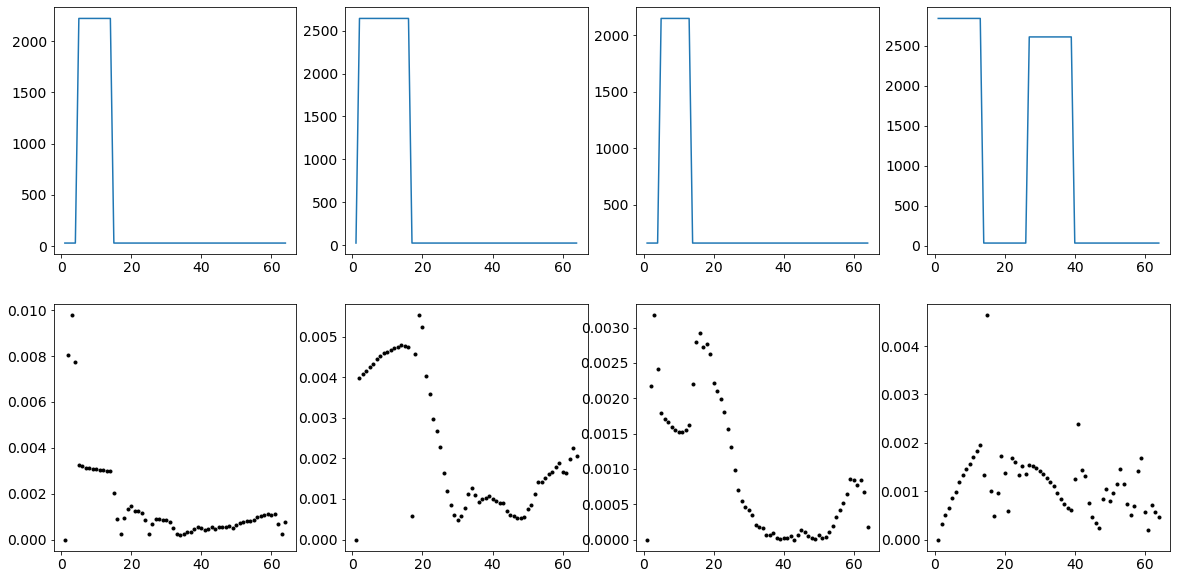

In [54]:
test_pred_C8_rel_error = np.abs(test_pred_C8.reshape(100, 64) - test_press_1day_64pixel) / test_press_1day_64pixel

# draw predicted pressure curves for test perm data
pixel = 64
fig, ax = plt.subplots(2, 4)
fig.set_size_inches(20, 10, forward=True)
ax[0, 0].plot(range(1, pixel + 1), test_perm_64pixel[55])
ax[1, 0].plot(range(1, pixel + 1), test_pred_C8_rel_error[55], 'k.')
ax[0, 1].plot(range(1, pixel + 1), test_perm_64pixel[14])
ax[1, 1].plot(range(1, pixel + 1), test_pred_C8_rel_error[14], 'k.', lw = 1)
ax[0, 2].plot(range(1, pixel + 1), test_perm_64pixel[64])
ax[1, 2].plot(range(1, pixel + 1), test_pred_C8_rel_error[64], 'k.', lw = 1)
ax[0, 3].plot(range(1, pixel + 1), test_perm_64pixel[21])
ax[1, 3].plot(range(1, pixel + 1), test_pred_C8_rel_error[21], 'k.', lw = 1)

(array([2.927e+03, 1.423e+03, 7.510e+02, 4.610e+02, 2.490e+02, 1.730e+02,
        9.200e+01, 1.080e+02, 6.900e+01, 6.000e+01, 2.500e+01, 1.000e+01,
        3.000e+00, 9.000e+00, 7.000e+00, 7.000e+00, 3.000e+00, 3.000e+00,
        6.000e+00, 5.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 4.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([0.        , 0.00058628, 0.00117257, 0.00175885, 0.00234513,
        0.00293141, 0.0035177 , 0.00410398, 0.00469026, 0.00527654,
        0.00586283, 0.00644911, 0.00703539, 0.00762168, 0.00820796,
        0.00879424, 0.00938052, 0.00996681, 0.01055309, 0.01113937,
        0.01172566, 0.01231194, 0.01289822, 0.0134845 , 0.01407079,
        0.01465707, 0.01524335, 0.01582963, 0.01641592, 0.0170022 ,
        0.01758848]),
 <a list of 30 Patch objects>)

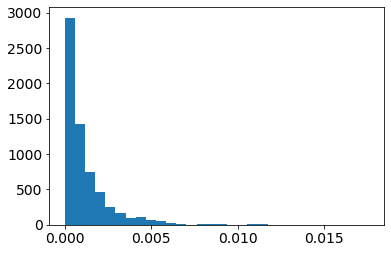

In [55]:
plt.hist(test_pred_C8_rel_error.reshape(-1), bins = 30)

In [56]:
print(np.mean(test_pred_C8_rel_error))

print(np.var(test_pred_C8_rel_error))

0.0011687285639386653
2.1294207863725125e-06


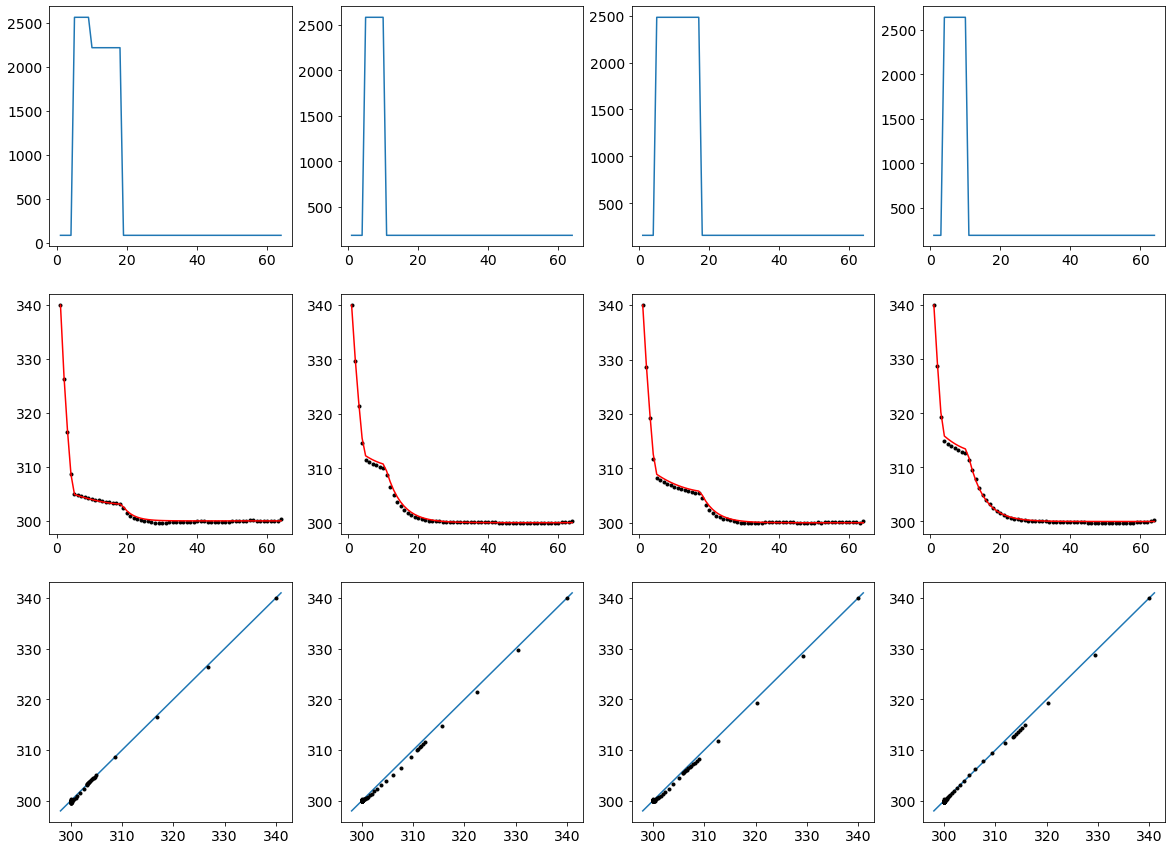

In [57]:
# draw predicted pressure curves for test perm data
pixel = 64
fig, ax = plt.subplots(3, 4)
fig.set_size_inches(20, 15, forward=True)
ax[0, 0].plot(range(1, pixel + 1), test_perm_64pixel[15])
ax[1, 0].plot(range(1, pixel + 1), test_pred_C8[15], 'k.')
ax[1, 0].plot(range(1, pixel + 1), test_press_1day_64pixel[15], 'r-')
ax[2, 0].plot(range(298, 342), range(298, 342))
ax[2, 0].plot(test_press_1day_64pixel[15], test_pred_C8[15], 'k.')

ax[0, 1].plot(range(1, pixel + 1), test_perm_64pixel[74])
ax[1, 1].plot(range(1, pixel + 1), test_pred_C8[74], 'k.')
ax[1, 1].plot(range(1, pixel + 1), test_press_1day_64pixel[74], 'r-')
ax[2, 1].plot(range(298, 342), range(298, 342))
ax[2, 1].plot(test_press_1day_64pixel[74], test_pred_C8[74], 'k.')

ax[0, 2].plot(range(1, pixel + 1), test_perm_64pixel[32])
ax[1, 2].plot(range(1, pixel + 1), test_pred_C8[32], 'k.')
ax[1, 2].plot(range(1, pixel + 1), test_press_1day_64pixel[32], 'r-')
ax[2, 2].plot(range(298, 342), range(298, 342))
ax[2, 2].plot(test_press_1day_64pixel[32], test_pred_C8[32], 'k.')

ax[0, 3].plot(range(1, pixel + 1), test_perm_64pixel[98])
ax[1, 3].plot(range(1, pixel + 1), test_pred_C8[98], 'k.')
ax[1, 3].plot(range(1, pixel + 1), test_press_1day_64pixel[98], 'r-') 
ax[2, 3].plot(range(298, 342), range(298, 342))
ax[2, 3].plot(test_press_1day_64pixel[98], test_pred_C8[98], 'k.')

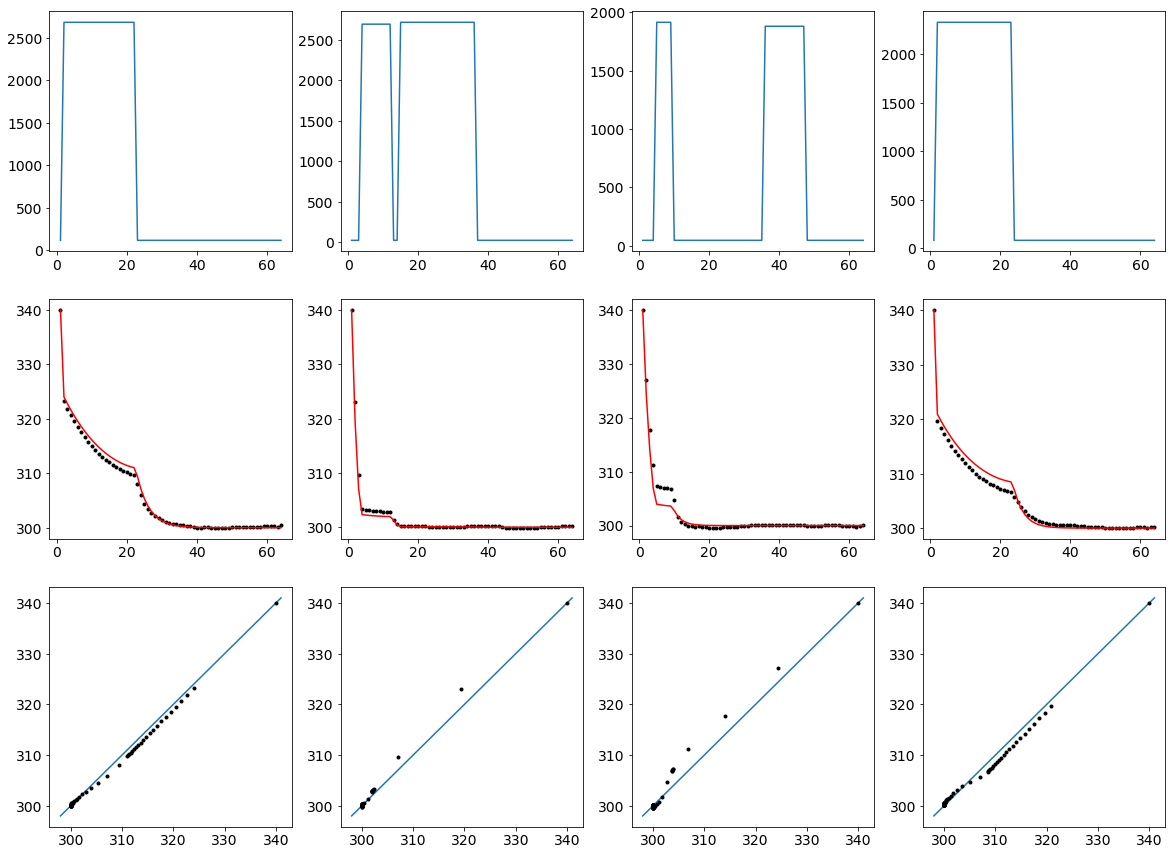

In [58]:
# draw predicted pressure curves for test perm data
test_index = [3, 46, 60, 91]

pixel = 64
fig, ax = plt.subplots(3, 4)
fig.set_size_inches(20, 15, forward=True)
ax[0, 0].plot(range(1, pixel + 1), test_perm_64pixel[test_index[0]])
ax[1, 0].plot(range(1, pixel + 1), test_pred_C8[test_index[0]], 'k.')
ax[1, 0].plot(range(1, pixel + 1), test_press_1day_64pixel[test_index[0]], 'r-')
ax[2, 0].plot(range(298, 342), range(298, 342))
ax[2, 0].plot(test_press_1day_64pixel[test_index[0]], test_pred_C8[test_index[0]], 'k.')

ax[0, 1].plot(range(1, pixel + 1), test_perm_64pixel[test_index[1]])
ax[1, 1].plot(range(1, pixel + 1), test_pred_C8[test_index[1]], 'k.')
ax[1, 1].plot(range(1, pixel + 1), test_press_1day_64pixel[test_index[1]], 'r-')
ax[2, 1].plot(range(298, 342), range(298, 342))
ax[2, 1].plot(test_press_1day_64pixel[test_index[1]], test_pred_C8[test_index[1]], 'k.')

ax[0, 2].plot(range(1, pixel + 1), test_perm_64pixel[test_index[2]])
ax[1, 2].plot(range(1, pixel + 1), test_pred_C8[test_index[2]], 'k.')
ax[1, 2].plot(range(1, pixel + 1), test_press_1day_64pixel[test_index[2]], 'r-')
ax[2, 2].plot(range(298, 342), range(298, 342))
ax[2, 2].plot(test_press_1day_64pixel[test_index[2]], test_pred_C8[test_index[2]], 'k.')

ax[0, 3].plot(range(1, pixel + 1), test_perm_64pixel[test_index[3]])
ax[1, 3].plot(range(1, pixel + 1), test_pred_C8[test_index[3]], 'k.')
ax[1, 3].plot(range(1, pixel + 1), test_press_1day_64pixel[test_index[3]], 'r-') 
ax[2, 3].plot(range(298, 342), range(298, 342))
ax[2, 3].plot(test_press_1day_64pixel[test_index[3]], test_pred_C8[test_index[3]], 'k.')

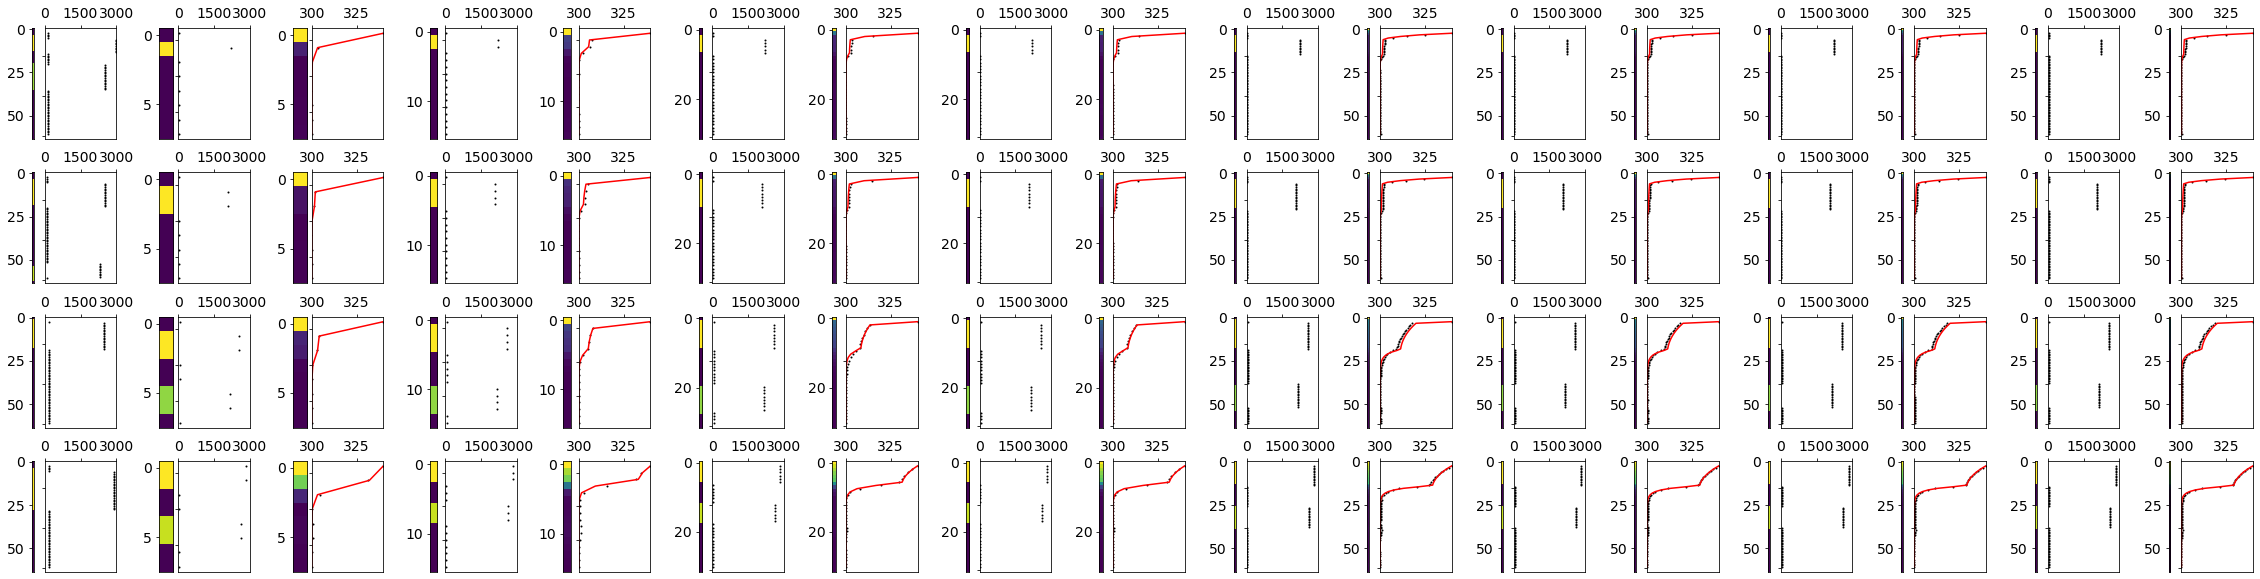

In [59]:
plt.rcParams.update({'font.size': 14})

test_perm_64pixel_2d = np.expand_dims(test_perm_64pixel, axis = -1)
test_perm_32pixel_2d = np.expand_dims(test_perm_32pixel, axis = -1)
test_perm_16pixel_2d = np.expand_dims(test_perm_16pixel, axis = -1)
test_perm_8pixel_2d = np.expand_dims(test_perm_8pixel, axis = -1)

test_press_1day_64pixel_2d = np.expand_dims(test_press_1day_64pixel, axis = -1)
test_press_1day_32pixel_2d = np.expand_dims(test_press_1day_32pixel, axis = -1)
test_press_1day_16pixel_2d = np.expand_dims(test_press_1day_16pixel, axis = -1)
test_press_1day_8pixel_2d = np.expand_dims(test_press_1day_8pixel, axis = -1)

test_ind_list = [55, 1, 2, 21]
ex_no = len(test_ind_list)

fig, ax = plt.subplots(4, 17)
fig.set_size_inches(40, 10, forward=True)
fig.subplots_adjust(wspace=0.4, hspace=0.3)

# 0th column
for i in range(ex_no):
    ax[i, 0].set_frame_on(False)
    ax[i, 0].tick_params(bottom=False, left=False)
    ax[i, 0].set(xticks=[], yticks=[])  # remove the tick lab
    ax_left = ax[i, 0].inset_axes([0., 0., 0.25, 1])
    ax_right = ax[i, 0].inset_axes([0.25, 0., 0.75, 1])
    ax_left.imshow(perm_curves_64_2d[test_ind_list[i]])
    ax_left.tick_params(bottom=False)  # remove the ticks
    ax_left.set(xticks=[])  # remove the tick lab
    ax_right.plot(perm_curves_64_2d[test_ind_list[i],::-1], range(1, 65), 'k.', markersize=2)
    ax_right.tick_params(axis='x', top=True, bottom = False)  # Set ticks on the top of X-axis
    ax_right.xaxis.set_tick_params(labeltop=True, labelbottom = False)
    ax_right.tick_params(axis='y', left=True)  # Set ticks on the top of y-axis
    ax_right.yaxis.set_tick_params(labelleft= False)
    ax_right.set_xlim(0, 3000)
    ax_right.xaxis.set_ticks((0, 1500, 3000))
    

perms_2d_list = [test_perm_8pixel_2d, test_perm_16pixel_2d, test_perm_32pixel_2d, test_perm_32pixel_2d, test_perm_64pixel_2d, test_perm_64pixel_2d, test_perm_64pixel_2d, test_perm_64pixel_2d]    
out_grid_list = [8, 16, 32, 32, 64, 64, 64, 64]
pres_2d_list = [test_pred_C1, test_pred_C2, test_pred_C3, test_pred_C4, test_pred_C5, test_pred_C6, test_pred_C7, test_pred_C8]
pres_ecl_list = [test_press_1day_8pixel, test_press_1day_16pixel, test_press_1day_32pixel, test_press_1day_32pixel, test_press_1day_64pixel, test_press_1day_64pixel, test_press_1day_64pixel, test_press_1day_64pixel]

for c in range(8):
    perm_2d = perms_2d_list[c]
    grid_ = out_grid_list[c]
    pres_2d = pres_2d_list[c]
    pres_ecl = pres_ecl_list[c]
    # cth column
    for i in range(ex_no):
        ax[i, 2*c+1].set_frame_on(False)
        ax[i, 2*c+1].tick_params(bottom=False, left=False)
        ax[i, 2*c+1].set(xticks=[], yticks=[])  # remove the tick lab
        ax_left = ax[i, 2*c+1].inset_axes([0., 0., 0.25, 1])
        ax_right = ax[i, 2*c+1].inset_axes([0.25, 0., 0.75, 1])
        ax_left.imshow(perm_2d[test_ind_list[i]])
        ax_left.tick_params(bottom=False)  # remove the ticks
        ax_left.set(xticks=[])  # remove the tick lab
        ax_right.plot(perm_2d[test_ind_list[i],::-1], range(1, grid_+1), 'k.', markersize=2)
        ax_right.tick_params(axis='x', top=True, bottom = False)  # Set ticks on the top of X-axis
        ax_right.xaxis.set_tick_params(labeltop=True, labelbottom = False)
        ax_right.tick_params(axis='y', left=True)  # Set ticks on the top of y-axis
        ax_right.yaxis.set_tick_params(labelleft= False)
        ax_right.set_xlim(0, 3000)
        ax_right.xaxis.set_ticks((0, 1500, 3000))    
        
        ax[i, 2*c+2].set_frame_on(False)
        ax[i, 2*c+2].tick_params(bottom=False, left=False)
        ax[i, 2*c+2].set(xticks=[], yticks=[])  # remove the tick lab
        ax_left = ax[i, 2*c+2].inset_axes([0., 0., 0.25, 1])
        ax_right = ax[i, 2*c+2].inset_axes([0.25, 0., 0.75, 1])
        ax_left.imshow(pres_2d[test_ind_list[i]])
        ax_left.tick_params(bottom=False)  # remove the ticks
        ax_left.set(xticks=[])  # remove the tick lab
        ax_right.plot(pres_2d[test_ind_list[i],::-1], range(1, grid_+1), 'k.', markersize=2)
        ax_right.plot(pres_ecl[test_ind_list[i],::-1], range(1, grid_+1), 'r-')  
        ax_right.tick_params(axis='x', top=True, bottom = False)  # Set ticks on the top of X-axis
        ax_right.xaxis.set_tick_params(labeltop=True, labelbottom = False)
        ax_right.tick_params(axis='y', left=True)  # Set ticks on the top of y-axis
        ax_right.yaxis.set_tick_params(labelleft= False)
        ax_right.set_xlim(300, 340)
        #ax_right.xaxis.set_ticks((0, 1500, 3000))        

In [ ]:
test_perm_64pixel

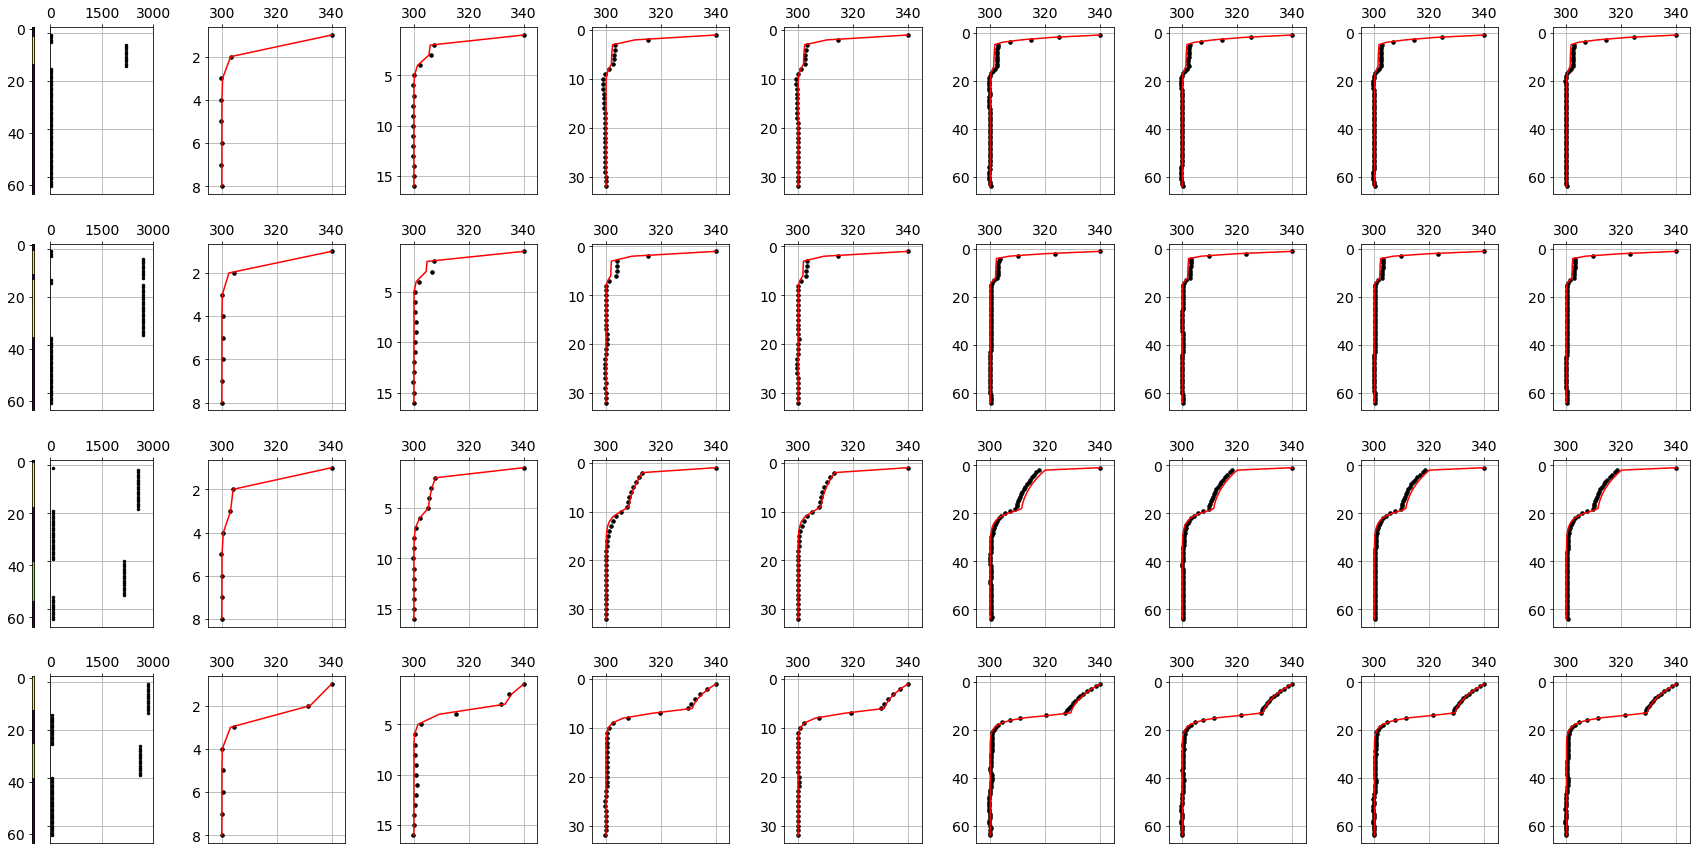

In [65]:
plt.rcParams.update({'font.size': 14})

test_perm_64pixel_2d = np.expand_dims(test_perm_64pixel, axis = -1)
test_perm_32pixel_2d = np.expand_dims(test_perm_32pixel, axis = -1)
test_perm_16pixel_2d = np.expand_dims(test_perm_16pixel, axis = -1)
test_perm_8pixel_2d = np.expand_dims(test_perm_8pixel, axis = -1)

test_press_1day_64pixel_2d = np.expand_dims(test_press_1day_64pixel, axis = -1)
test_press_1day_32pixel_2d = np.expand_dims(test_press_1day_32pixel, axis = -1)
test_press_1day_16pixel_2d = np.expand_dims(test_press_1day_16pixel, axis = -1)
test_press_1day_8pixel_2d = np.expand_dims(test_press_1day_8pixel, axis = -1)

test_ind_list = [55, 46, 2, 21]
ex_no = len(test_ind_list)

fig, ax = plt.subplots(4, 9)
fig.set_size_inches(30, 15, forward=True)
fig.subplots_adjust(wspace=0.4, hspace=0.3)

# 0th column
for i in range(ex_no):
    ax[i, 0].set_frame_on(False)
    ax[i, 0].tick_params(bottom=False, left=False)
    ax[i, 0].set(xticks=[], yticks=[])  # remove the tick lab
    ax_left = ax[i, 0].inset_axes([0., 0., 0.25, 1])
    ax_right = ax[i, 0].inset_axes([0.25, 0., 0.75, 1])
    ax_left.imshow(test_perm_64pixel_2d[test_ind_list[i]])
    ax_left.tick_params(bottom=False)  # remove the ticks
    ax_left.set(xticks=[])  # remove the tick lab
    ax_right.plot(test_perm_64pixel_2d[test_ind_list[i]], range(1, 65), 'k.', markersize=5)
    ax_right.invert_yaxis()
    ax_right.grid(True)
    ax_right.tick_params(axis='x', top=True, bottom = False)  # Set ticks on the top of X-axis
    ax_right.xaxis.set_tick_params(labeltop=True, labelbottom = False)
    ax_right.tick_params(axis='y', left=True)  # Set ticks on the top of y-axis
    ax_right.yaxis.set_tick_params(labelleft= False)
    ax_right.set_xlim(0, 3000)
    ax_right.xaxis.set_ticks((0, 1500, 3000))
    

perms_2d_list = [test_perm_8pixel_2d, test_perm_16pixel_2d, test_perm_32pixel_2d, test_perm_32pixel_2d, test_perm_64pixel_2d, test_perm_64pixel_2d, test_perm_64pixel_2d, test_perm_64pixel_2d]    
out_grid_list = [8, 16, 32, 32, 64, 64, 64, 64]
pres_2d_list = [test_pred_C1, test_pred_C2, test_pred_C3, test_pred_C4, test_pred_C5, test_pred_C6, test_pred_C7, test_pred_C8]
pres_ecl_list = [test_press_1day_8pixel, test_press_1day_16pixel, test_press_1day_32pixel, test_press_1day_32pixel, test_press_1day_64pixel, test_press_1day_64pixel, test_press_1day_64pixel, test_press_1day_64pixel]

for c in range(8):
    perm_2d = perms_2d_list[c]
    grid_ = out_grid_list[c]
    pres_2d = pres_2d_list[c]
    pres_ecl = pres_ecl_list[c]
    # cth column
    for i in range(ex_no):   
        ax[i, c+1].plot(pres_2d[test_ind_list[i]], range(1, grid_+1), 'k.', markersize=7)
        ax[i, c+1].plot(pres_ecl[test_ind_list[i]], range(1, grid_+1), 'r-') 
        ax[i, c+1].invert_yaxis()
        ax[i, c+1].grid(True)
        ax[i, c+1].tick_params(axis='x', top=True, bottom = False)  # Set ticks on the top of X-axis
        ax[i, c+1].xaxis.set_tick_params(labeltop=True, labelbottom = False)
        ax[i, c+1].set_xlim(295, 345)


In [59]:

bound_sta_value = 340
bound_end_value = 300

test_pred_C8_rel_error = np.abs(test_pred_C8.reshape(100, 64) - test_press_1day_64pixel) / ((bound_sta_value-bound_end_value))

test_pred_C8_rel_error.shape

In [66]:
test_res_1day_64pixel_ecl = np.zeros((test_press_1day_64pixel.shape[0], test_press_1day_64pixel.shape[1]))
test_res_1day_64pixel_ecl[:, 1:-1] = residual_matrix(test_perm_64pixel[:, np.newaxis, :], test_press_1day_64pixel[:,:,np.newaxis])[:,:,0]
test_res_1day_64pixel_ecl.shape

(100, 64)

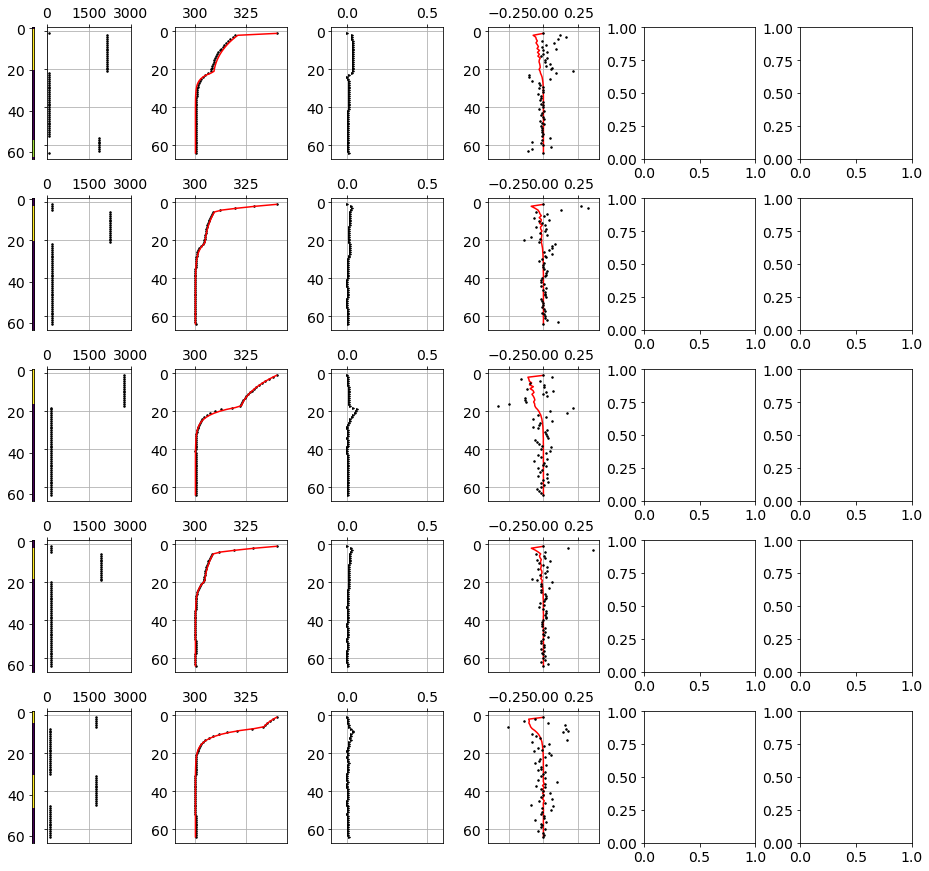

In [67]:
plt.rcParams.update({'font.size': 14})

test_perm_64pixel_2d = np.expand_dims(test_perm_64pixel, axis = -1)
test_press_1day_64pixel_2d = np.expand_dims(test_press_1day_64pixel, axis = -1)

test_ind_list = [11, 12, 23, 35, 59]
ex_no = len(test_ind_list)

fig, ax = plt.subplots(5, 6)
fig.set_size_inches(16, 15, forward=True)
fig.subplots_adjust(wspace=0.4, hspace=0.3)


for i in range(ex_no):
    ax[i, 0].set_frame_on(False)
    ax[i, 0].tick_params(bottom=False, left=False)
    ax[i, 0].set(xticks=[], yticks=[])  # remove the tick lab
    ax_left = ax[i, 0].inset_axes([0., 0., 0.25, 1])
    ax_right = ax[i, 0].inset_axes([0.25, 0., 0.75, 1])
    ax_left.imshow(test_perm_64pixel_2d[test_ind_list[i]])
    ax_left.tick_params(bottom=False)  # remove the ticks
    ax_left.set(xticks=[])  # remove the tick lab
    ax_right.plot(test_perm_64pixel_2d[test_ind_list[i]], range(1, 65), 'k.', markersize=3)
    ax_right.invert_yaxis()
    ax_right.tick_params(axis='x', top=True, bottom = False)  # Set ticks on the top of X-axis
    ax_right.xaxis.set_tick_params(labeltop=True, labelbottom = False)
    ax_right.tick_params(axis='y', left=True)  # Set ticks on the top of y-axis
    ax_right.yaxis.set_tick_params(labelleft= False)
    ax_right.grid(True)
    ax_right.set_xlim(0, 3000)
    ax_right.xaxis.set_ticks((0, 1500, 3000))
    
    ax[i, 1].plot(test_pred_C8[test_ind_list[i]], range(1, 65), 'k.', markersize=3)
    ax[i, 1].plot(test_press_1day_64pixel[test_ind_list[i]], range(1, 65), 'r-') 
    ax[i, 1].invert_yaxis()
    ax[i, 1].tick_params(axis='x', top=True, bottom = False)  # Set ticks on the top of X-axis
    ax[i, 1].xaxis.set_tick_params(labeltop=True, labelbottom = False)
    ax[i, 1].grid(True)
    ax[i, 1].set_xlim(290, 345)
    
    ax[i, 2].plot(test_pred_C8_rel_error[test_ind_list[i]], range(1, 65), 'k>', markersize=2)
    ax[i, 2].invert_yaxis()
    ax[i, 2].grid(True)
    ax[i, 2].tick_params(axis='x', top=True, bottom = False)  # Set ticks on the top of X-axis
    ax[i, 2].xaxis.set_tick_params(labeltop=True, labelbottom = False)
    ax[i, 2].set_xlim(-0.1, 0.6)
    

    
    ax[i, 3].plot(test_res_1day_64pixel_ecl[test_ind_list[i]], range(1, 65), 'r-')
    ax[i, 3].plot(test_res_C8[test_ind_list[i]], range(1, 65), 'k.', markersize=3)
    ax[i, 3].invert_yaxis()
    ax[i, 3].grid(True)
    ax[i, 3].tick_params(axis='x', top=True, bottom = False)  # Set ticks on the top of X-axis
    ax[i, 3].xaxis.set_tick_params(labeltop=True, labelbottom = False)
    ax[i, 3].set_xlim(-0.4, 0.4)    

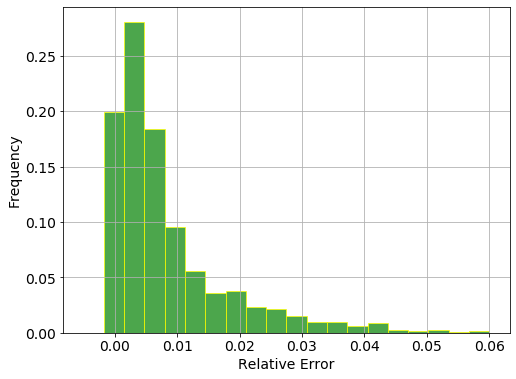

In [71]:
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(8, 6))

error = test_pred_C8_rel_error.reshape(-1)
plt.hist(error, bins = 20, ec="yellow", fc="g", alpha=0.7, weights=np.zeros_like(error) + 1. / len(error), range = (-0.005, 0.06))
# 
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
# plt.title('Histogram of IQ')
plt.grid(True)

#plt.savefig(Sur_network_dir + "Hist_R2 error.png", dpi=150) 

In [72]:
error_mean = np.mean(error)
error_std = np.std(error)

print(error_mean)
print(error_std)

0.008838020972209279
0.011284811135954347


In [74]:
res_ecl_mean = np.mean(np.abs(test_res_1day_64pixel_ecl))
res_ecl_std = np.std(np.abs(test_res_1day_64pixel_ecl))
print(res_ecl_mean)
print(res_ecl_std)

res_C8_mean = np.mean(np.abs(test_res_C8))
res_C8_std = np.std(np.abs(test_res_C8))
print(res_C8_mean)
print(res_C8_std)

0.010529525633306775
0.021351746062560427
0.04025831579401938
0.07662379219354908


In [76]:
mg_time_V1_st = time.time()

test_perms = [test_perm_8pixel]
test_ini_res = np.zeros(test_perm_8pixel.shape)
test_ini_pred = np.zeros(test_perm_8pixel.shape)
test_res_i = test_ini_res
test_pred_i = test_ini_pred
for i in range(len(NNs_pipl_C1_list)):
    NNs_pipl_C1_i = NNs_pipl_C1_list[i]    
    test_pred_i, test_res_i = NNs_pipl_C1_i.mapping(test_perms, test_res_i, test_pred_i)
test_pred_C1 = test_pred_i
test_res_C1 = test_res_i    

test_perms = [test_perm_16pixel, test_perm_8pixel]
test_pred_C1_up = upscale(test_pred_C1)
test_res_C1_up = np.zeros((test_pred_C1_up.shape[0], test_pred_C1_up.shape[1]))
test_res_C1_up[:, 1:-1] = residual_matrix(test_perm_16pixel[:, np.newaxis, :], test_pred_C1_up)[:,:,0]
test_pred_C2, test_res_C2 = NNs_pipl_C2.mapping(test_perms, test_res_C1_up, test_pred_C1_up)

test_perms = [test_perm_32pixel, test_perm_16pixel, test_perm_8pixel]
test_pred_C2_up = upscale(test_pred_C2)
test_res_C2_up = np.zeros((test_pred_C2_up.shape[0], test_pred_C2_up.shape[1]))
test_res_C2_up[:, 1:-1] = residual_matrix(test_perm_32pixel[:, np.newaxis, :], test_pred_C2_up)[:,:,0]
test_pred_C3, test_res_C3 = NNs_pipl_C3.mapping(test_perms, test_res_C2_up, test_pred_C2_up)

test_perms = [test_perm_32pixel, test_perm_16pixel, test_perm_8pixel]
# predict pressure curves using NN pipelines for test permeability curves
test_pred_C4, test_res_C4 = NNs_pipl_C4.mapping(test_perms, test_res_C3, test_pred_C3)

test_perms = [test_perm_64pixel, test_perm_32pixel, test_perm_16pixel, test_perm_8pixel]
test_pred_C4_up = upscale(test_pred_C4)
test_res_C4_up = np.zeros((test_pred_C4_up.shape[0], test_pred_C4_up.shape[1]))
test_res_C4_up[:, 1:-1] = residual_matrix(test_perm_64pixel[:, np.newaxis, :], test_pred_C4_up)[:,:,0]
# predict pressure curves using NN pipelines for test permeability curves
test_pred_C5, test_res_C5 = NNs_pipl_C5.mapping(test_perms, test_res_C4_up, test_pred_C4_up)

test_perms = [test_perm_64pixel, test_perm_32pixel, test_perm_16pixel, test_perm_8pixel]
test_pred_C6, test_res_C6 = NNs_pipl_C6.mapping(test_perms, test_res_C5, test_pred_C5)

test_perms = [test_perm_64pixel, test_perm_32pixel]
# predict pressure curves using NN pipelines for test permeability curves
test_pred_C7, test_res_C7 = NNs_pipl_C7.mapping(test_perms, test_res_C6, test_pred_C6)

test_perms = [test_perm_64pixel]
# predict pressure curves using NN pipelines for test permeability curves
test_pred_C8, test_res_C8 = NNs_pipl_C8.mapping(test_perms, test_res_C7, test_pred_C7)

mg_time_V1_ed = time.time()
print('Seconds used: ' + str(mg_time_V1_ed - mg_time_V1_st))
print("Seconds used for each perm curve:" + str((mg_time_V1_ed - mg_time_V1_st)/100))

Seconds used: 1.8441848754882812
Seconds used for each perm curve:0.018441848754882813
